In [1]:
#always
import os
#global variables

strain='/n/groups/datta/rockwell/k2_data_gen3/longtogeny/LONG_AND_ONT/'
results_file = '/n/groups/datta/Dana'
pc_scores='/n/groups/datta/rockwell/k2_data_gen3/longtogeny/LONG_AND_ONT/220323_pca/pca_scores.h5'
#get this index file by generating/copying from oringal locatoin
index_file = '/n/groups/datta/rockwell/k2_data_gen3/longtogeny/LONG_AND_ONT/220323_long_and_ont_moseq6-index.yaml'
#model_file = '/Users/rockwell/Code/210610_reconstructed_results/210610_longtogeny_model3_tar.p'
model_file = '/n/groups/datta/rockwell/k2_data_gen3/longtogeny/LONG_AND_ONT/220323_long_ont_model_robust_s1.p'
'''
strain='/n/groups/datta/Dana/new_figs/'
pc_scores='/n/groups/datta/rockwell/k2_data_gen3/longtogeny/LONG_AND_ONT/220415_pca/pca_scores.h5'
#get this index file by generating/copying from oringal locatoin
index_file = '/n/groups/datta/rockwell/k2_data_gen3/longtogeny/LONG_AND_ONT/220415_long_and_ont_moseq6-index.yaml'
#model_file = '/Users/rockwell/Code/210610_reconstructed_results/210610_longtogeny_model3_tar.p'
model_file = '/n/groups/datta/rockwell/k2_data_gen3/longtogeny/LONG_AND_ONT/220415_long_ont_model_robust_s1.p'
'''
n_training_mice=.93 #percent of mice to be used for training
use_post_hoc_sort=False
seed=28
compnumc=3
n_training_mice=6
n_syllables_to_plot=91
max_syllable=91
gep_color_mat=['limegreen', 'peru', 'silver']

'''
data_loc=strain+'_data'
try:
    os.mkdir(data_loc)
except FileExistsError:
    # directory already exists
    pass

os.chdir(data_loc)
'''

"\ndata_loc=strain+'_data'\ntry:\n    os.mkdir(data_loc)\nexcept FileExistsError:\n    # directory already exists\n    pass\n\nos.chdir(data_loc)\n"

In [2]:
#standard library imports
import copy
import pylab
from sklearn.manifold import TSNE
import h5py
import scipy
import datetime
import math
import cmasher as cmr
seqmatcolor='Purples_r'
divmatcolor=cmr.watermelon_r
from matplotlib.lines import Line2D
from matplotlib_venn import venn3
from scipy import linalg as LA
import glob
import yaml
from scipy.stats import linregress
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.datasets import make_blobs
import pandas as pd
from collections import Counter
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
np.random.seed(123456)
import pickle
import seaborn as sns
from scipy.spatial.distance import squareform
import warnings
from statistics import median
warnings.filterwarnings("ignore", category=DeprecationWarning) 
%matplotlib inline

In [3]:
#moseq imports
from moseq2_viz.model.util import parse_model_results
from moseq2_viz.util import parse_index
from moseq2_viz.scalars.util import scalars_to_dataframe
from moseq2_viz.model.dist import get_behavioral_distance

# Behavioral Distance Dependencies
from scipy.cluster.hierarchy import linkage, dendrogram

# Transition Matrices Compute/Graphing Dependencies
from moseq2_viz.model.util import parse_model_results, relabel_by_usage
from moseq2_viz.model.trans_graph import get_trans_graph_groups, get_group_trans_mats

# -----------------------------------------------------------------------
# -----------------------------------------------------------------------
# FUNCTIONS
# -----------------------------------------------------------------------
# -----------------------------------------------------------------------

In [4]:
def subset_label_counts(counts,uuids_conditions,condition):
    m=[]
    for i in range(len(uuids_conditions)):
        if str(uuids_conditions[i][1])[0:2] == condition:
            m.append(counts[i])
        if str(uuids_conditions[i][2])[0:2] == condition:
            m.append(counts[i])
        if str(uuids_conditions[i][2])[17:19] == condition:
            m.append(counts[i])
    return np.array(m)

In [5]:
def subset_labels(labels,uuids_conditions,condition):
    m=[]
    u=[]
    for i in range(len(uuids_conditions)):
        if str(uuids_conditions[i][1])[0:2] == condition:
            m.append(labels[i])
            u.append(uuids_conditions[i][0])
        if str(uuids_conditions[i][2])[0:2] == condition:
            m.append(labels[i])
            u.append(uuids_conditions[i][0])
        if str(uuids_conditions[i][2])[17:19] == condition:
            m.append(labels[i])
            u.append(uuids_conditions[i][0])
    return np.array(m),u


In [6]:
def labels_and_scalars(labels,results_file,uuids_conditions,a_scalar='velocity_2d_mm',condition='12'):
    ljm,bhj=get_subsetted_scalars(a_scalar,condition,uuids_conditions,results_file)
    gerf,onon=subset_labels(labels,uuids_conditions,condition)
    da_real=[]
    for n in onon:
        #print(bhj.index(n))
        da_real.append(bhj.index(n))
    return gerf, np.array(ljm)[da_real], onon

In [7]:
def normalize(a):
    norm_a=a/(np.max(a)-np.min(a))
    norm_a=a/(np.max(a)-np.min(a)) 
    return(norm_a)


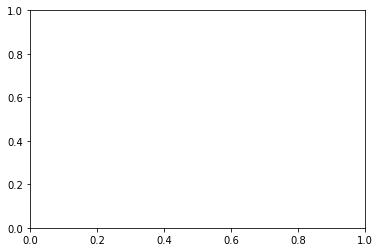

In [8]:
fig,ax=plt.subplots()
def plot_size_corr(l,s,syllable=0,color='black',ax=ax):
    hjkjkg=[]
    gbfgbfdfd=[]
    
    for i in range(len(l)):
        if sum(l[i]==syllable) != 0:
            try:

                hjkjkg.append(  sum(l[i]==syllable) /  sum(l[i]>-4)   )
                gbfgbfdfd.append(np.nanmedian(s[i]))
            except:
                pass
    
    #x=weight y=usage
    ax.scatter(gbfgbfdfd,hjkjkg,color=color) 
    idxpp = np.isfinite(hjkjkg) & np.isfinite(gbfgbfdfd)
    
    z = np.polyfit(gbfgbfdfd,hjkjkg,  1)
    p = np.poly1d(z)
    ax.plot(gbfgbfdfd,p(gbfgbfdfd),color=color,linestyle='--')

In [9]:
def get_subsetted_scalars(a_scalar,condition,uuids_conditions,directory):
    
    #accessing scalar data from results files
    here=os.getcwd()
    os.chdir(directory) #if the directory contains the session folders directly then you dont need the */ in front of session in the glob.glob below

    result_h5_files=[] #create an empty matrix that will contain the addresses of the result files
    for file in glob.glob("*/session*/proc/*.h5"):
        result_h5_files.append(file)
        #print(file)


    result_h5_uuid=[] #create an empty matrix that will contain the addresses of the result files
    for file in glob.glob("*/session*/proc/*.yaml"):
        with open(file) as f:
            y=yaml.load(f)
            ido=y['uuid']
            result_h5_uuid.append(ido)
            #print(id)
        f.close()
    f.close()


    scalar=[]
    associated_uuid=[]
    i=0
    j=0
    for u in result_h5_uuid:
        for uc in uuids_conditions:
            if u == uc[0]:
                if str(uc[1])[0:2] == condition:
                    results_h5_data = h5py.File(result_h5_files[i], 'r+')
                    x=results_h5_data['scalars'][a_scalar]
                    scalar.append(np.array(x))
                    associated_uuid.append(u)

                if str(uc[2])[0:2] == condition:
                    results_h5_data = h5py.File(result_h5_files[i], 'r+')
                    x=results_h5_data['scalars'][a_scalar]
                    scalar.append(np.array(x))
                    associated_uuid.append(u)

                if str(uc[2])[17:19] == condition:
                    results_h5_data = h5py.File(result_h5_files[i], 'r+')
                    x=results_h5_data['scalars'][a_scalar]
                    scalar.append(np.array(x))
                    associated_uuid.append(u)
            j=j+1
        i=i+1
        j=0
    os.chdir(here)
    return scalar,associated_uuid

In [10]:
def pca_on_np_array(nparray):
    '''rows are members (mice), columns are variables (syllables)'''
    nparray -= np.mean(nparray, axis = 0)  
    #calculate covariance matrix
    cov = np.cov(nparray, rowvar = False)
    #get eigenvectors and eigenvalues
    evals , evecs = LA.eigh(cov)

    #formatting and SORT by eigenvalues (aka sort by how much variance each eigen vector explains)
    idx = np.argsort(evals)[::-1]
    evecs = evecs[:,idx]
    evals = evals[idx]

    #this is your data represented as PCS 
    nparray_represented_as_pcs = np.dot(nparray, evecs)
    
    return nparray_represented_as_pcs,evecs,evals

In [11]:
def trans_mat_diff(trans_mats,tm1,tm2):

    #normalize both input matrices
    tma=trans_mats[tm1]/(np.max(trans_mats[tm1])-np.min(trans_mats[tm1]))
    tmb=trans_mats[tm2]/(np.max(trans_mats[tm2])-np.min(trans_mats[tm2]))

    tmdiff=np.subtract(tmb,tma)
    
    return tmdiff

In [12]:
def shuffle_along_axis(a, axis):
    idx = np.random.rand(*a.shape).argsort(axis=axis)
    return np.take_along_axis(a,idx,axis=axis)

In [13]:
def counttrigram(ooga,cutoff):
    n=3
    gram_mat=np.zeros(([100]*n))
    i=ooga[2]
    j=ooga[3]
    k=ooga[4]
    for c in range(3,len(ooga)-2):
        if ooga[c] != -5 and ooga[c+1] != -5 and ooga[c+2] != -5:
            if ooga[c] < cutoff and ooga[c+1] < cutoff and ooga[c+2] < cutoff:  
                i=ooga[c]
                j=ooga[c+1]
                k=ooga[c+2]
                gram_mat[i][j][k]=gram_mat[i][j][k]+1

    return gram_mat
    

In [14]:
def plot_a_syllable(s,s_description='',legend=False):

    from matplotlib.lines import Line2D
    custom_lines = [Line2D([0], [0], color=color_mat[0], lw=4),
                    Line2D([0], [0], color=color_mat[1], lw=4),
                    Line2D([0], [0], color=color_mat[2], lw=4),
                    Line2D([0], [0], color=color_mat[3], lw=4),
                    Line2D([0], [0], color=color_mat[4], lw=4),
                    Line2D([0], [0], color=color_mat[5], lw=4),
                    Line2D([0], [0], color=color_mat[6], lw=4),
                    Line2D([0], [0], color=color_mat[7], lw=4)]


    fig, ax = plt.subplots()
    fig.set_size_inches(3,8)
    plt.title(s_description,fontsize=17)
    a=sns.pointplot(data=frequencies[0][:,s],ax=ax,label=age_labels[0],linestyles='',markersize=5,color=color_mat[0])
    b=sns.pointplot(data=frequencies[1][:,s],ax=ax,label=age_labels[1],linestyles='',markersize=5,color=color_mat[1])
    c=sns.pointplot(data=frequencies[2][:,s],ax=ax,label=age_labels[2],linestyles='',markersize=5,color=color_mat[2])
    d=sns.pointplot(data=frequencies[3][:,s],ax=ax,label=age_labels[3],linestyles='',markersize=5,color=color_mat[3])
    e=sns.pointplot(data=frequencies[4][:,s],ax=ax,label=age_labels[4],linestyles='',markersize=5,color=color_mat[4])
    f=sns.pointplot(data=frequencies[5][:,s],ax=ax,label=age_labels[5],linestyles='',markersize=5,color=color_mat[5])
    g=sns.pointplot(data=frequencies[6][:,s],ax=ax,label=age_labels[6],linestyles='',markersize=5,color=color_mat[6])
    h=sns.pointplot(data=frequencies[7][:,s],ax=ax,label=age_labels[7],linestyles='',markersize=5,color=color_mat[7])

    ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
    ax.set_xticks([])
    #ax.set_xlim([-1,(max_syllable-.5)])
    if legend:
        plt.legend(handles=custom_lines,labels=cohort_labels,bbox_to_anchor=(1.05, 1),loc='upper left')

    plt.xlabel('Syllable_' + str(s),fontsize=17)
    plt.ylabel('Frequency',fontsize=17)
    fig.patch.set_facecolor('white')
    plt.show()

In [15]:
def get_best_nmf(datamat,uptoncomps=10,restarts=10,save=False,title='nmf_performance',howtocalc='use_sum'):
    from sklearn.decomposition import NMF
    import scipy.cluster.hierarchy as hc
    from numpy import inf
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_score
    Hs=[]
    for c in range(2,uptoncomps):
        Hn=[]
        for r in range(restarts):    
            model = NMF(n_components=c, init='random', random_state=r)
            W = model.fit_transform(datamat)
            H = model.components_
            Hn.append(H)
        Hs.append(Hn)
        
    fig, ax = plt.subplots(1,uptoncomps-2) 
    fig.set_size_inches((uptoncomps-2)*4,(uptoncomps-2))
    
    
    for hhh in range(len(Hs)):
        
        wrf=np.zeros((restarts,restarts))
        for i in range(len(Hs[0])):
            for j in range(restarts):
                for k in range(restarts):
                    if howtocalc=='use_sum':
                        corrrr=np.corrcoef(x=np.sum(Hs[hhh][j],axis=0),y=np.sum(Hs[hhh][k],axis=0)) 
                    if howtocalc=='use_var':
                        corrrr=np.corrcoef(x=np.var(Hs[hhh][j],axis=0),y=np.var(Hs[hhh][k],axis=0)) 
                    if howtocalc=='use_entropy':
                        try:
                            corrrr=scipy.stats.entropy(pk=Hs[hhh][j],qk=Hs[hhh][k],axis=0)
                            corrrr[corrrr == inf] = 1
                        except:
                            corrrr=0
                    #print(np.mean(corrrr))
                    if howtocalc != 'use_entropy':
                        wrf[j][k]=corrrr[0,1]
                    if howtocalc == 'use_entropy':
                        wrf[j][k]=np.nanmedian(corrrr)

        ax[hhh].set_xticks([]) 
        ax[hhh].set_yticks([])    
        #ax[hhh].imshow(wrf,cmap='gray',vmin=0, vmax=1)
        
        #sns.clustermap(wrf,cmap='gray',vmin=0, vmax=1,ax=ax[hhh])

        
        d=pd.DataFrame(wrf)
        link = hc.linkage(d.values, method='centroid')
        o1 = hc.leaves_list(link)
        mat = d.iloc[o1,:]
        mat = mat.iloc[:, o1[::-1]]
        ax[hhh].imshow(mat,cmap='gist_earth',vmin=0, vmax=1)
        
        kmeans = KMeans(init="random",n_clusters=3,n_init=10,max_iter=300,random_state=28)
        kmeans.fit(wrf)
        score = silhouette_score(wrf, kmeans.labels_)
        
        #ax[hhh].set_title(str(hhh+2)+ ' groups (' + str(np.mean(wrf))[0:5] + ')')#use entopy of values to determine best "cluster"
        #ax[hhh].set_title(str(hhh+2)+ ' groups (' + str(scipy.stats.entropy(wrf))[0:5] + ')')
        ax[hhh].set_title(str(hhh+2)+ ' groups (' + str(kmeans.inertia_)[0:5] + ')') #use kmeans inertia
        #ax[hhh].set_title(str(hhh+2)+ ' groups (' + str(score)[0:5] + ')') #use kmeans silhoutte scores
        
        
    fraction = .04  # .05
    norm = mpl.colors.Normalize(vmin=0, vmax=1)
    cbar = ax[hhh].figure.colorbar(
    mpl.cm.ScalarMappable(norm=norm, cmap='gist_earth'),
    ax=ax[hhh], pad=0, fraction=fraction)
    fig.patch.set_facecolor('white')

    plt.show()
    
    if save:
        fig.savefig((title)+".pdf",  bbox_inches='tight')
        fig.savefig((title)+".png",  bbox_inches='tight')
        
    return Hs

In [16]:
def return_confusion(predictions):
    cnf_mat=np.zeros((len(predictions),len(predictions)))
    for i in range(len(predictions)):
        for j in range(len(predictions)):
            cnf_mat[i,j]=np.count_nonzero(predictions[i]==j) / len(predictions[i])
    return cnf_mat
    

In [17]:
#can chance based on number of pcs
def contribution_of_each_syllable_to_distance(nparray1,nparray2,npcs=10):
    pcs,eigenvectors,eigenvalues=pca_on_np_array(np.concatenate((nparray1,nparray2),axis=0))

    n_mice1=len(nparray1)
    n_mice2=len(nparray2)
    n_syllables=len(nparray1[0])

    #get the mean pc scores for each group
    group1_mean_pcs=np.mean(pcs[0:(n_mice1-1)],axis=0)
    group2_mean_pcs=np.mean(pcs[n_mice1:((n_mice1+n_mice2)-1)],axis=0)
    #calculate the absolute pairwise difference between pcs and divide by the sum 
    difference=np.abs(np.subtract(group1_mean_pcs,group2_mean_pcs))
    square_difference=np.square(difference)
    sum_of_square_difference=sum(square_difference)
    weighted_difference=square_difference/sum_of_square_difference

    #calculate how much each syllable contributes to each eigenvector and ultimately the distance between groups
    contribution_of_each_syllable=np.zeros((n_syllables,n_syllables),dtype=float)
    for i in range(n_syllables):
        pc_i_contribution_to_all_syllables=weighted_difference[i]*np.square(eigenvectors[:,i])*((eigenvalues[i]**2/sum(eigenvalues**2)))
        contribution_of_each_syllable[i,:]=pc_i_contribution_to_all_syllables
    
    contribution_of_each_syllable=sum(contribution_of_each_syllable[0:npcs])/sum(sum(contribution_of_each_syllable)[0:npcs])
    
    return contribution_of_each_syllable

In [18]:
def plot_scalars(results_file,scalar_of_interest,ylim=False):
    ''' angle
        area_mm
        area_px
        centroid_x_mm
        centroid_x_px
        centroid_y_mm
        centroid_y_px
        height_ave_mm
        length_mm
        length_px
        velocity_2d_mm
        velocity_2d_px
        velocity_3d_mm
        velocity_3d_px
        velocity_theta
        width_mm
        width_px'''
    vel2d_03w,uuid_03w=get_subsetted_scalars(scalar_of_interest,'03',uuids_conditions,results_file)
    vel2d_05w,uuid_05w=get_subsetted_scalars(scalar_of_interest,'05',uuids_conditions,results_file)
    vel2d_07w,uuid_07w=get_subsetted_scalars(scalar_of_interest,'07',uuids_conditions,results_file)
    vel2d_09w,uuid_09w=get_subsetted_scalars(scalar_of_interest,'90',uuids_conditions,results_file)
    vel2d_03m,uuid_03m=get_subsetted_scalars(scalar_of_interest,'3m',uuids_conditions,results_file)
    vel2d_06m,uuid_06m=get_subsetted_scalars(scalar_of_interest,'6m',uuids_conditions,results_file)
    vel2d_12m,uuid_12m=get_subsetted_scalars(scalar_of_interest,'12',uuids_conditions,results_file)
    vel2d_18m,uuid_18m=get_subsetted_scalars(scalar_of_interest,'18',uuids_conditions,results_file)

    a_scalar_means_03w=[]
    for i in range(len(vel2d_03w)):
        a_scalar_means_03w.append(np.nanmean(vel2d_03w[i]))

    a_scalar_means_05w=[]
    for i in range(len(vel2d_05w)):
        a_scalar_means_05w.append(np.nanmean(vel2d_05w[i]))

    a_scalar_means_07w=[]
    for i in range(len(vel2d_07w)):
        a_scalar_means_07w.append(np.nanmean(vel2d_07w[i]))

    a_scalar_means_09w=[]
    for i in range(len(vel2d_09w)):
        a_scalar_means_09w.append(np.nanmean(vel2d_09w[i]))

    a_scalar_means_03m=[]
    for i in range(len(vel2d_03m)):
        a_scalar_means_03m.append(np.nanmean(vel2d_03m[i]))

    a_scalar_means_06m=[]
    for i in range(len(vel2d_06m)):
        a_scalar_means_06m.append(np.nanmean(vel2d_06m[i]))

    a_scalar_means_12m=[]
    for i in range(len(vel2d_12m)):
        a_scalar_means_12m.append(np.nanmean(vel2d_12m[i]))

    a_scalar_means_18m=[]
    for i in range(len(vel2d_18m)):
        a_scalar_means_18m.append(np.nanmean(vel2d_18m[i]))

    a_scalar_means_data=[a_scalar_means_03w,a_scalar_means_05w,a_scalar_means_07w,a_scalar_means_09w,
                         a_scalar_means_03m,a_scalar_means_06m,a_scalar_means_12m,a_scalar_means_18m]

    fig ,ax=plt.subplots()
    fig.set_size_inches(16,4)
    sns.boxplot(data=a_scalar_means_data)
    plt.xticks(plt.xticks()[0], cohort_labels)
    if ylim:
        ax.set_ylim(ylim)
    plt.title(strain + ' ' + scalar_of_interest)
    plt.show()
    fig.savefig(strain + '_' + scalar_of_interest + '_scalar_plot.pdf', bbox_inches='tight')
    fig.savefig(strain + '_' + scalar_of_interest + '_scalar_plot.png', bbox_inches='tight')

In [19]:
def unique(list1):
 
    # intilize a null list
    unique_list = []
     
    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)
    return unique_list

In [20]:
def to_integer(dt_time):
    return 10000*dt_time.year + 100*dt_time.month + dt_time.day

def int_to_datetime(date):
    date=str(date)
    a=date[0:4]
    b=date[4:6]
    c=date[6:8]
    return datetime.date(int(a), int(b), int(c))

# LOAD DATA AND QUALITY CONTROL


In [21]:
#if max syllables in the original learn model is less than 100, then you cannot sort labels by usage here
model_results = parse_model_results(model_file,sort_labels_by_usage=True) 
index, sorted_index = parse_index(index_file)

FileNotFoundError: [Errno 2] No such file or directory: '/n/groups/datta/rockwell/k2_data_gen3/longtogeny/LONG_AND_ONT/220323_long_ont_model_robust_s1.p'

In [ ]:
#list(model_data) #get the syllable labels and the uuids (keys) from the model file
model_labels=model_results['labels']
model_keys=model_results['keys']
index_keys_and_fields=[]

#get the uuids (keys) and the user-entered metadata from the index file as well as the date of the session
for n in sorted_index['files']:
    #find the session numbers
    index_of_str_session=sorted_index['files'][n]['path'][0].index('session')
    #find the experiment (all experiment id start with the str "rec" (short for reconstructed))
    index_of_str_rec=sorted_index['files'][n]['path'][0].index('rec')
    index_keys_and_fields.append([n,
                             sorted_index['files'][n]['metadata']['SubjectName'],
                             sorted_index['files'][n]['metadata']['SessionName'],
                             sorted_index['files'][n]['path'][0][index_of_str_session+8:index_of_str_session+16],
                             sorted_index['files'][n]['path'][0][index_of_str_rec:index_of_str_rec+12]])
    
'''with open(strain + 'conditions_.pkl', 'wb') as f:
    pickle.dump(uuids_conditions, f)
    f.close()'''

In [ ]:
individual_longtogeny_males=[]
individual_longtogeny_females=[]
individual_ontogeny_males=[]

ikf1=np.array(index_keys_and_fields)[:,1]
ikf2=np.array(index_keys_and_fields)[:,2]
ikf4=np.array(index_keys_and_fields)[:,4]

for i in range(len(ikf1)):
    if 'rec_lon_male' in ikf4[i]:
        if ('m' not in ikf1[i]) and ('d' not in ikf1[i]) and ('5' not in ikf1[i]):
            individual_longtogeny_males.append(ikf1[i][0:5])
    if 'rec_lon_fema' in ikf4[i]:
        if ('m' not in ikf1[i]) and ('d' not in ikf1[i]):
            individual_longtogeny_females.append(ikf1[i][0:5])
    if 'rec_ont_male' in ikf4[i]:
        individual_ontogeny_males.append(ikf2[i][0:20] + '_' + ikf1[i][0:20])
            
unique_individual_longtogeny_males=unique(individual_longtogeny_males)
unique_individual_longtogeny_males.sort()
unique_individual_longtogeny_females=unique(individual_longtogeny_females)
unique_individual_longtogeny_females.sort()
unique_individual_ontogeny_males=unique(individual_ontogeny_males)
unique_individual_ontogeny_males.sort()

In [ ]:
#create different index_key_field variables for the three experiments

rec_lon_male_index_keys_and_fields=[]
rec_lon_fema_index_keys_and_fields=[]
rec_ont_male_index_keys_and_fields=[]

for n in index_keys_and_fields:
    if 'rec_lon_male' in n[4]:
        rec_lon_male_index_keys_and_fields.append(n)
        
for n in index_keys_and_fields:
    if 'rec_lon_fema' in n[4]:
        rec_lon_fema_index_keys_and_fields.append(n)
        
for n in index_keys_and_fields:
    if 'rec_ont_male' in n[4]:
        rec_ont_male_index_keys_and_fields.append(n)

In [ ]:
#remove aging and nor and default from male/female lontogeny sessions

#male
corruption=True
while corruption:
    for n in range(len(rec_lon_male_index_keys_and_fields)):
        if ('a' in rec_lon_male_index_keys_and_fields[n][1]) or ('d' in rec_lon_male_index_keys_and_fields[n][1]) or ('n' in rec_lon_male_index_keys_and_fields[n][1]) or ('a' in rec_lon_male_index_keys_and_fields[n][2]) or ('d' in rec_lon_male_index_keys_and_fields[n][2]) or ('n' in rec_lon_male_index_keys_and_fields[n][2]):
            #print(index_keys_and_fields[n])
            corruption=True
            rec_lon_male_index_keys_and_fields.pop(n)
            break
        corruption=False
    #print('males purged')

        #females
corruption=True
while corruption:
    for n in range(len(rec_lon_fema_index_keys_and_fields)):
        if ('a' in rec_lon_fema_index_keys_and_fields[n][1]) or ('d' in rec_lon_fema_index_keys_and_fields[n][1]) or ('n' in rec_lon_fema_index_keys_and_fields[n][1]) or ('a' in rec_lon_fema_index_keys_and_fields[n][2]) or ('d' in rec_lon_fema_index_keys_and_fields[n][2]) or ('n' in rec_lon_fema_index_keys_and_fields[n][2]):
            #print(index_keys_and_fields[n])
            corruption=True
            rec_lon_fema_index_keys_and_fields.pop(n)
            break
        corruption=False
    #print('females purged')

In [ ]:
male_dates=unique(np.array(rec_lon_male_index_keys_and_fields)[:,3])
male_dates.sort()

female_dates=unique(np.array(rec_lon_fema_index_keys_and_fields)[:,3])
female_dates.sort()

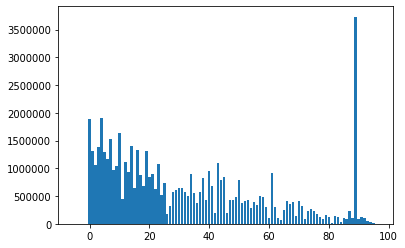

In [27]:
#show the syllable length across all sessions. unusually long ones are usually noisy syllables 
data_concatenated=np.hstack(copy.copy(model_labels))
c = Counter(data_concatenated)
plt.bar(c.keys(), c.values())
plt.show()

In [28]:
#sort longtogeny labels by the date (can also sort the individuals later)

#males longtogeny

male_sorted_labels=[]
male_linear_sorted_fields=[]
male_linear_sorted_labels=[]
for d in male_dates:
    labels_for_d_date=[]
    for k in rec_lon_male_index_keys_and_fields:
        if d == k[3] and (('m' not in k[1]) or ('a' not in k[1]) or ('n' not in k[1]) or ('m' not in k[2]) or ('a' not in k[2]) or ('n' not in k[2])):
            try:
                mdl_k_and_l_id=model_keys.index(k[0])
                labels_for_d_date.append(copy.copy(model_labels)[mdl_k_and_l_id])
                male_linear_sorted_fields.append((k[1][0:2],k[1][3:5],k[3]))
                male_linear_sorted_labels.append(copy.copy(model_labels)[mdl_k_and_l_id])
            except:
                pass
    male_sorted_labels.append(labels_for_d_date)

#females longtogeny

female_sorted_labels=[]
female_linear_sorted_fields=[]
female_linear_sorted_labels=[]
for d in female_dates:
    labels_for_d_date=[]
    for k in rec_lon_fema_index_keys_and_fields:
        if d == k[3] and (('m' not in k[1]) or ('a' not in k[1]) or ('n' not in k[1]) or ('m' not in k[2]) or ('a' not in k[2]) or ('n' not in k[2])):
            try:
                mdl_k_and_l_id=model_keys.index(k[0])
                labels_for_d_date.append(copy.copy(model_labels)[mdl_k_and_l_id])
                female_linear_sorted_fields.append((k[1][0:2],k[1][3:5],k[3]))
                female_linear_sorted_labels.append(copy.copy(model_labels)[mdl_k_and_l_id])
            except:
                pass
    female_sorted_labels.append(labels_for_d_date)

In [29]:
# get noise syllable
ms=max(c.values())
nos_ind = list(c.values()).index(ms)
nos_syl=list(c.keys())[nos_ind]

In [30]:
#based on the dates, create age labels that will be used for plots
age_of_mouse_at_time_zero_in_days=24

male_age_labels=[]
for n in male_dates:
    d=int_to_datetime(n)-int_to_datetime(male_dates[0])
    male_age_labels.append(str(d.days + age_of_mouse_at_time_zero_in_days))
    
female_age_labels=[]
for n in female_dates:
    d=int_to_datetime(n)-int_to_datetime(female_dates[0])
    female_age_labels.append(str(d.days + age_of_mouse_at_time_zero_in_days))

In [31]:
#sort ontogeny labels by group 
#ontogeny has 8 groups
ontogeny_groups=['3_weeks','5_weeks','7_weeks','9_weeks','3_months','6_months','12_months','18_months']
#they can be identified by unique strings in the unique_individual_ontogeny_males list
#these unique strings are:
ontogeny_group_string_identifiers=['y_03','y_05','y_07','y_09','3m_o','6m_o','_12m_','_18m_']

ontogeny_sorted_labels=[]
ontogeny_linear_sorted_fields=[]
ontogeny_linear_sorted_labels=[]

for g in ontogeny_group_string_identifiers:
    labels_for_group_d=[]
    for k in rec_ont_male_index_keys_and_fields:
        string_to_cross_reference=k[2][0:20] + '_' + k[1][0:20]
        if g in string_to_cross_reference:
            try:
                mdl_k_and_l_id=model_keys.index(k[0])
                labels_for_group_d.append(copy.copy(model_labels)[mdl_k_and_l_id])
                ontogeny_linear_sorted_fields.append(ontogeny_groups[ontogeny_group_string_identifiers.index(g)])
                ontogeny_linear_sorted_labels.append(copy.copy(model_labels)[mdl_k_and_l_id])
            except:
                pass
    ontogeny_sorted_labels.append(labels_for_group_d)            

In [32]:
#sort ontogeny labels by group 
#ontogeny has 8 groups
ontogeny_groups=['3_weeks','5_weeks','7_weeks','9_weeks','3_months','6_months','12_months','18_months']
#they can be identified by unique strings in the unique_individual_ontogeny_males list
#these unique strings are:
ontogeny_group_string_identifiers=['y_03','y_05','y_07','y_09','3m_o','6m_o','_12m_','_18m_']


ontogeny_sorted_labels=[]
ontogeny_linear_sorted_fields=[]
ontogeny_linear_sorted_labels=[]


for g in ontogeny_group_string_identifiers:
    labels_for_group_d=[]
    for k in rec_ont_male_index_keys_and_fields:
        string_to_cross_reference=k[2][0:20] + '_' + k[1][0:20]
        #print(string_to_cross_reference)
        if g in string_to_cross_reference:
            try:
                mdl_k_and_l_id=model_keys.index(k[0])
                labels_for_group_d.append(copy.copy(model_labels)[mdl_k_and_l_id])
                ontogeny_linear_sorted_fields.append(ontogeny_groups[ontogeny_group_string_identifiers.index(g)])
                ontogeny_linear_sorted_labels.append(copy.copy(model_labels)[mdl_k_and_l_id])

            except:
                pass
        #add missing ontogeny data d    
        if g == 'y_03' and '_3wk_' in string_to_cross_reference:
            try:
                mdl_k_and_l_id=model_keys.index(k[0])
                labels_for_group_d.append(copy.copy(model_labels)[mdl_k_and_l_id])
                ontogeny_linear_sorted_fields.append(ontogeny_groups[ontogeny_group_string_identifiers.index(g)])
                ontogeny_linear_sorted_labels.append(copy.copy(model_labels)[mdl_k_and_l_id])
                print('3 weeks straggers worked')
            except:
                pass
        if g == 'y_05' and '_5wk_' in string_to_cross_reference:
            try:
                mdl_k_and_l_id=model_keys.index(k[0])
                labels_for_group_d.append(copy.copy(model_labels)[mdl_k_and_l_id])
                ontogeny_linear_sorted_fields.append(ontogeny_groups[ontogeny_group_string_identifiers.index(g)])
                ontogeny_linear_sorted_labels.append(copy.copy(model_labels)[mdl_k_and_l_id])
            except:
                pass
        if g == 'y_07' and '_7wk_' in string_to_cross_reference:
            try:
                mdl_k_and_l_id=model_keys.index(k[0])
                labels_for_group_d.append(copy.copy(model_labels)[mdl_k_and_l_id])
                ontogeny_linear_sorted_fields.append(ontogeny_groups[ontogeny_group_string_identifiers.index(g)])
                ontogeny_linear_sorted_labels.append(copy.copy(model_labels)[mdl_k_and_l_id])
            except:
                pass
        if g == 'y_09' and '_9wk_' in string_to_cross_reference:
            try:
                mdl_k_and_l_id=model_keys.index(k[0])
                labels_for_group_d.append(copy.copy(model_labels)[mdl_k_and_l_id])
                ontogeny_linear_sorted_fields.append(ontogeny_groups[ontogeny_group_string_identifiers.index(g)])
                ontogeny_linear_sorted_labels.append(copy.copy(model_labels)[mdl_k_and_l_id])
            except:
                pass
            
    ontogeny_sorted_labels.append(labels_for_group_d)   

3 weeks straggers worked
3 weeks straggers worked
3 weeks straggers worked
3 weeks straggers worked
3 weeks straggers worked
3 weeks straggers worked
3 weeks straggers worked
3 weeks straggers worked
3 weeks straggers worked
3 weeks straggers worked
3 weeks straggers worked


In [33]:
#convert the sequential labels into matrices that contain the syllable counts. (male longtogeny)
#THIS CHANGES MODEL LABELS SOMEONE
male_all_label_frequency_counts=[]
for sl in male_sorted_labels[:]:
    male_label_frequency_counts=np.zeros(((len(sl)),100),dtype=float)

    for i in range((len(sl))):
        #list of labels
        m=sl[i][:]

        cv=Counter(m)
        count=np.fromiter(cv.values(),dtype=int)
        syllable=np.fromiter(cv.keys(),dtype=int)
        for j in range(len(count)):
            male_label_frequency_counts[i][syllable[j]]=count[j]
        male_label_frequency_counts[i][-5]=0
    male_all_label_frequency_counts.append(male_label_frequency_counts)
male_linear_sorted_frequencies=list(np.vstack(male_all_label_frequency_counts))

print(len(male_linear_sorted_fields))
print(len(male_linear_sorted_labels))
print(len(male_linear_sorted_frequencies))

762
762
762


In [34]:
#convert the sequential labels into matrices that contain the syllable counts. (male longtogeny)
#THIS CHANGES MODEL LABELS SOMEONE
female_all_label_frequency_counts=[]
for sl in female_sorted_labels[:]:
    female_label_frequency_counts=np.zeros(((len(sl)),100),dtype=float)

    for i in range((len(sl))):
        #list of labels
        m=sl[i][:]

        cv=Counter(m)
        count=np.fromiter(cv.values(),dtype=int)
        syllable=np.fromiter(cv.keys(),dtype=int)
        for j in range(len(count)):
            female_label_frequency_counts[i][syllable[j]]=count[j]
        female_label_frequency_counts[i][-5]=0
    female_all_label_frequency_counts.append(female_label_frequency_counts)
female_linear_sorted_frequencies=list(np.vstack(female_all_label_frequency_counts))

print(len(female_linear_sorted_fields))
print(len(female_linear_sorted_labels))
print(len(female_linear_sorted_frequencies))

523
523
523


In [35]:
#convert the sequential labels into matrices that contain the syllable counts. (male longtogeny)
#THIS CHANGES MODEL LABELS SOMEONE
ontogeny_all_label_frequency_counts=[]
for sl in ontogeny_sorted_labels[:]:
    ontogeny_label_frequency_counts=np.zeros(((len(sl)),100),dtype=float)

    for i in range((len(sl))):
        #list of labels
        m=sl[i][:]

        cv=Counter(m)
        count=np.fromiter(cv.values(),dtype=int)
        syllable=np.fromiter(cv.keys(),dtype=int)
        for j in range(len(count)):
            ontogeny_label_frequency_counts[i][syllable[j]]=count[j]
        ontogeny_label_frequency_counts[i][-5]=0
    ontogeny_all_label_frequency_counts.append(ontogeny_label_frequency_counts)
ontogeny_linear_sorted_frequencies=list(np.vstack(ontogeny_all_label_frequency_counts))

print(len(ontogeny_linear_sorted_fields))
print(len(ontogeny_linear_sorted_labels))
print(len(ontogeny_linear_sorted_frequencies))

185
185
185


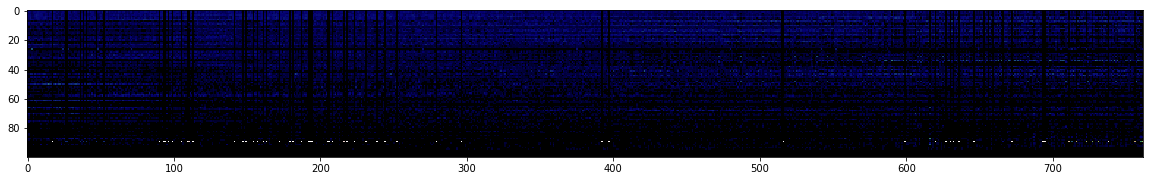

In [36]:
fig,ax=plt.subplots()
fig.set_size_inches(20,10)
plt.imshow(np.array(male_linear_sorted_frequencies).T,cmap='gist_earth')
plt.show()

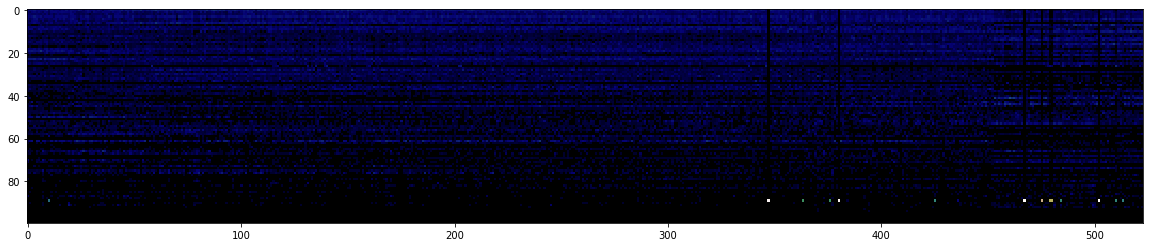

In [37]:
fig,ax=plt.subplots()
fig.set_size_inches(20,10)
plt.imshow(np.array(female_linear_sorted_frequencies).T,cmap='gist_earth')
plt.show()

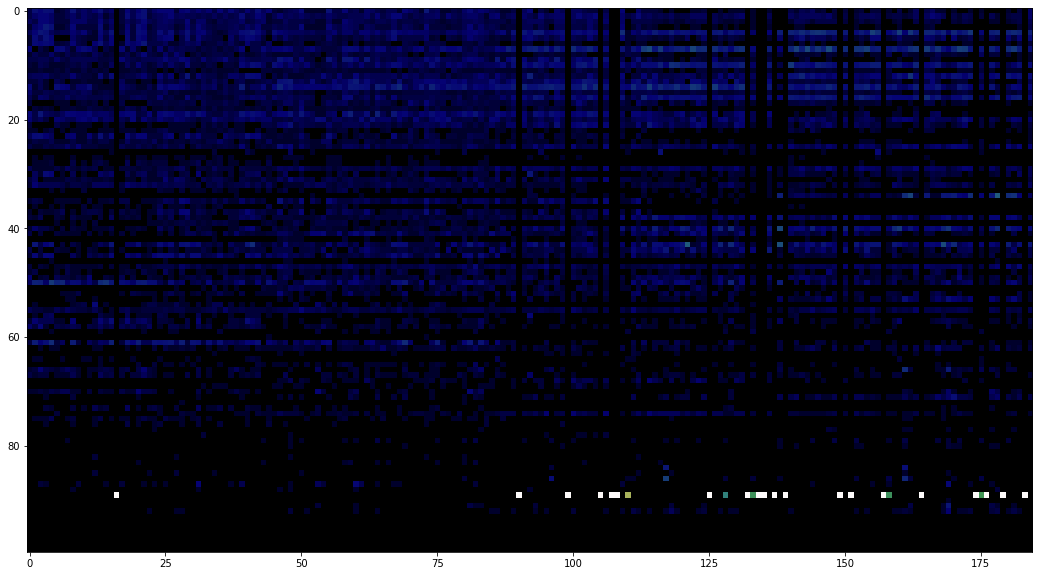

In [38]:
fig,ax=plt.subplots()
fig.set_size_inches(20,10)
plt.imshow(np.array(ontogeny_linear_sorted_frequencies).T,cmap='gist_earth')
plt.show()

In [39]:
#count the number of labels in each of the sessions
male_mice_per_day_pre_pop=[]
for a in male_all_label_frequency_counts:
    male_mice_per_day_pre_pop.append(len(a))
    
female_mice_per_day_pre_pop=[]
for a in female_all_label_frequency_counts:
    female_mice_per_day_pre_pop.append(len(a))
    
ontogeny_mice_per_day_pre_pop=[]
for a in ontogeny_all_label_frequency_counts:
    ontogeny_mice_per_day_pre_pop.append(len(a))

In [40]:
#sessions that only expressed less than 1000 syllables and median syllable is < 10 should be purged

#male longtogeny
corruption=True
while corruption:
    for n in range(len(male_linear_sorted_frequencies)):
        if sum(male_linear_sorted_frequencies[n])<=1000 or median(male_linear_sorted_frequencies[n])<=10:
            print(male_linear_sorted_fields[n])
            corruption=True
            male_linear_sorted_labels.pop(n)
            male_linear_sorted_frequencies.pop(n)
            male_linear_sorted_fields.pop(n)
            break
        corruption=False

#female longtogeny
corruption=True
while corruption:
    for n in range(len(female_linear_sorted_frequencies)):
        if sum(female_linear_sorted_frequencies[n])<=1000 or median(female_linear_sorted_frequencies[n])<=10:
            print(female_linear_sorted_fields[n])
            corruption=True
            female_linear_sorted_labels.pop(n)
            female_linear_sorted_frequencies.pop(n)
            female_linear_sorted_fields.pop(n)
            break
        corruption=False

#male ontogeny
corruption=True
while corruption:
    for n in range(len(ontogeny_linear_sorted_frequencies)):
        if sum(ontogeny_linear_sorted_frequencies[n])<=1000 or median(ontogeny_linear_sorted_frequencies[n])<=10:
            #print(ontogeny_linear_sorted_fields[n])
            corruption=True
            ontogeny_linear_sorted_labels.pop(n)
            ontogeny_linear_sorted_frequencies.pop(n)
            ontogeny_linear_sorted_fields.pop(n)
            break
        corruption=False

('03', '03', '20210331')
('04', '03', '20210401')
('02', '03', '20210401')
('03', '03', '20210402')
('01', '03', '20210402')
('04', '03', '20210402')
('01', '03', '20210403')
('03', '03', '20210403')
('04', '03', '20210406')
('04', '03', '20210407')
('01', '03', '20210407')
('02', '03', '20210407')
('03', '03', '20210407')
('03', '03', '20210408')
('02', '03', '20210408')
('04', '03', '20210408')
('01', '03', '20210408')
('02', '03', '20210420')
('04', '03', '20210420')
('01', '03', '20210420')
('03', '03', '20210420')
('01', '03', '20210423')
('02', '03', '20210423')
('03', '03', '20210423')
('04', '03', '20210426')
('01', '03', '20210426')
('03', '03', '20210426')
('04', '03', '20210503')
('01', '03', '20210503')
('02', '03', '20210503')
('03', '03', '20210503')
('01', '03', '20210506')
('04', '03', '20210506')
('03', '03', '20210506')
('01', '03', '20210510')
('03', '03', '20210510')
('02', '03', '20210510')
('04', '03', '20210510')
('03', '03', '20210514')
('02', '03', '20210514')


In [41]:
# turn noise syllable count to 0
for ind,mouse in enumerate(male_linear_sorted_frequencies):
    male_linear_sorted_frequencies[ind][nos_syl]=0

for ind,mouse in enumerate(female_linear_sorted_frequencies):
    female_linear_sorted_frequencies[ind][nos_syl]=0

for ind,mouse in enumerate(ontogeny_linear_sorted_frequencies):
    ontogeny_linear_sorted_frequencies[ind][nos_syl]=0

In [42]:
#make a new CLEAN all_label_frequency_counts variable (male longtogeny)
ttt=0
tttt=0
male_all_label_frequency_counts=[]
mice_this_day=[]
dates_used=[]
c_data_counter=male_linear_sorted_fields[0][2]
for n in range(len(male_linear_sorted_fields)):
    dates_used.append(male_linear_sorted_fields[n][2])
    if male_linear_sorted_fields[n][2]==c_data_counter:
        mice_this_day.append(male_linear_sorted_frequencies[n])

    if male_linear_sorted_fields[n][2] != c_data_counter:
        
        male_all_label_frequency_counts.append(mice_this_day)
        mice_this_day=[]
        mice_this_day.append(male_linear_sorted_frequencies[n])
        ttt+=1
        
        c_data_counter=male_linear_sorted_fields[n][2]
male_all_label_frequency_counts.append(mice_this_day)

#update_dates
male_dates=unique(np.array(dates_used))
male_dates.sort()
#based on the dates, create age labels that will be used for plots
age_of_mouse_at_time_zero_in_days=24
male_age_labels=[]
for n in male_dates:
    d=int_to_datetime(n)-int_to_datetime(male_dates[0])
    male_age_labels.append(str(d.days + age_of_mouse_at_time_zero_in_days))
    
print(len(male_linear_sorted_fields))
print(len(male_linear_sorted_labels))
print(len(male_linear_sorted_frequencies))
print(len(np.vstack(male_all_label_frequency_counts)))

696
696
696
696


In [43]:
#make a new CLEAN all_label_frequency_counts variable (female longtogeny)
ttt=0
tttt=0
female_all_label_frequency_counts=[]
mice_this_day=[]
dates_used=[]
c_data_counter=female_linear_sorted_fields[0][2]
for n in range(len(female_linear_sorted_fields)):
    dates_used.append(female_linear_sorted_fields[n][2])
    if female_linear_sorted_fields[n][2]==c_data_counter:
        mice_this_day.append(female_linear_sorted_frequencies[n])

    if female_linear_sorted_fields[n][2] != c_data_counter:
        
        female_all_label_frequency_counts.append(mice_this_day)
        mice_this_day=[]
        mice_this_day.append(female_linear_sorted_frequencies[n])
        ttt+=1
        
        c_data_counter=female_linear_sorted_fields[n][2]
female_all_label_frequency_counts.append(mice_this_day)

#update_dates
female_dates=unique(np.array(dates_used))
female_dates.sort()
#based on the dates, create age labels that will be used for plots
age_of_mouse_at_time_zero_in_days=24
female_age_labels=[]
for n in female_dates:
    d=int_to_datetime(n)-int_to_datetime(female_dates[0])
    female_age_labels.append(str(d.days + age_of_mouse_at_time_zero_in_days))
    
print(len(female_linear_sorted_fields))
print(len(female_linear_sorted_labels))
print(len(female_linear_sorted_frequencies))
print(len(np.vstack(female_all_label_frequency_counts)))

519
519
519
519


In [44]:
#make a new CLEAN all_label_frequency_counts variable (male ontogeny)
ttt=0
tttt=0
ontogeny_all_label_frequency_counts=[]
dates_used=[]
mice_this_day=[]
c_data_counter=ontogeny_linear_sorted_fields[0]
for n in range(len(ontogeny_linear_sorted_fields)):
    dates_used.append(ontogeny_linear_sorted_fields[n])
    if ontogeny_linear_sorted_fields[n]==c_data_counter:
        mice_this_day.append(ontogeny_linear_sorted_frequencies[n])

    if ontogeny_linear_sorted_fields[n] != c_data_counter: 
        ontogeny_all_label_frequency_counts.append(mice_this_day)
        mice_this_day=[]
        mice_this_day.append(ontogeny_linear_sorted_frequencies[n])
        ttt+=1
        
        c_data_counter=ontogeny_linear_sorted_fields[n]
ontogeny_all_label_frequency_counts.append(mice_this_day)

print(len(ontogeny_linear_sorted_fields))
print(len(ontogeny_linear_sorted_labels))
print(len(ontogeny_linear_sorted_frequencies))
print(len(np.vstack(ontogeny_all_label_frequency_counts)))

165
165
165
165


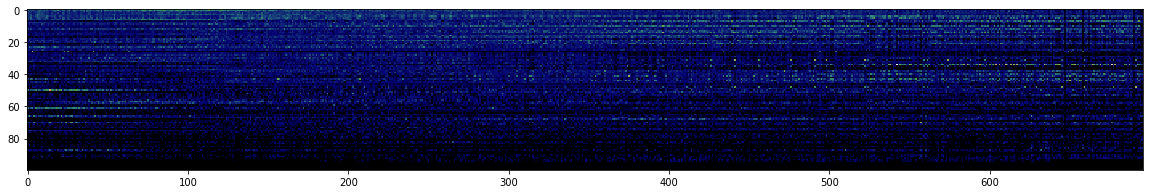

In [45]:
fig,ax=plt.subplots()
fig.set_size_inches(20,10)
plt.imshow(np.array(male_linear_sorted_frequencies).T,cmap='gist_earth')
plt.show()

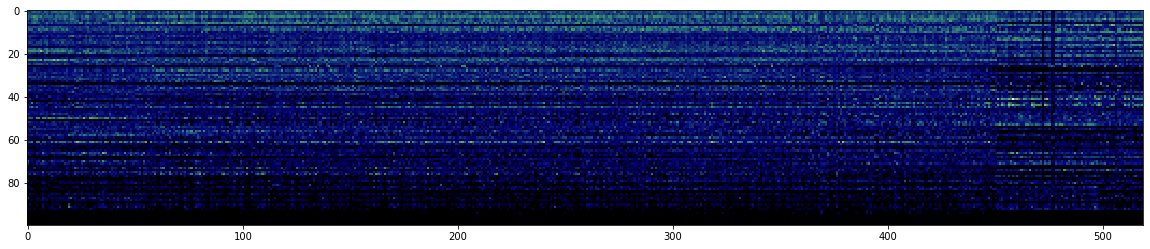

In [46]:
fig,ax=plt.subplots()
fig.set_size_inches(20,10)
plt.imshow(np.array(female_linear_sorted_frequencies).T,cmap='gist_earth')
plt.show()

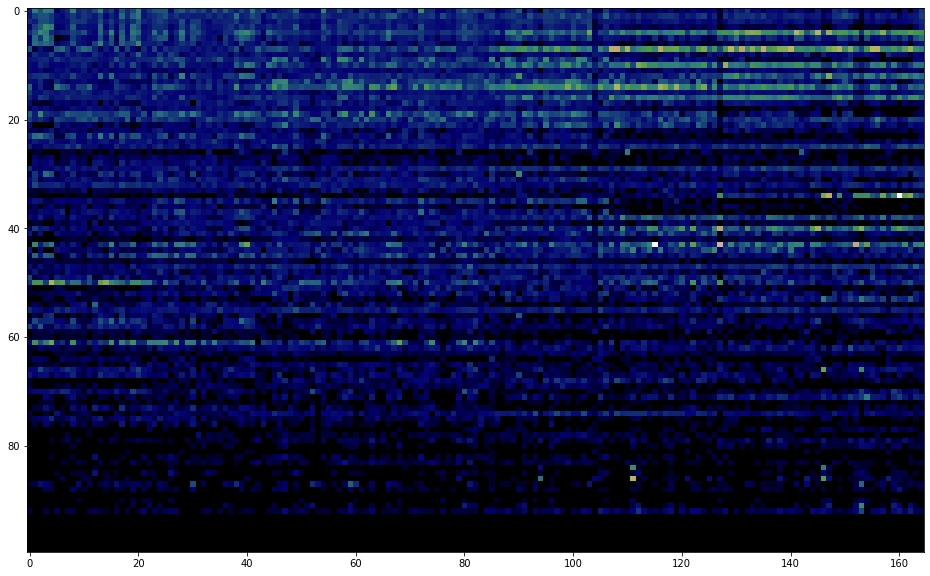

In [47]:
fig,ax=plt.subplots()
fig.set_size_inches(20,10)
plt.imshow(np.array(ontogeny_linear_sorted_frequencies).T,cmap='gist_earth')
plt.show()

In [48]:
#syllable frequency of individual longtogeny male/females

syllable_expression_of_individual_males=[]
for n in male_all_label_frequency_counts:
    try:
        mean_syllable_expressed_by_individual_male=((np.array(n).T/np.array(np.sum(n,axis=1))).T)
    except:
        pass
    syllable_expression_of_individual_males.append(mean_syllable_expressed_by_individual_male) 
    
syllable_expression_of_individual_females=[]
for n in female_all_label_frequency_counts:
    try:
        mean_syllable_expressed_by_individual_female=((np.array(n).T/np.array(np.sum(n,axis=1))).T)
    except:
        pass
    syllable_expression_of_individual_females.append(mean_syllable_expressed_by_individual_female)
    
syllable_expression_of_individual_ontogeny_mice=[]
for n in ontogeny_all_label_frequency_counts:
    try:
        mean_syllable_expressed_by_individual_ontogeny_mice=((np.array(n).T/np.array(np.sum(n,axis=1))).T)
    except:
        pass
    syllable_expression_of_individual_ontogeny_mice.append(mean_syllable_expressed_by_individual_ontogeny_mice)
    
    
#mean syllable frequency for each time point of longtogeny male/female or group for ontogeny male

male_syllable_expression_by_timepoint=[]

for n in syllable_expression_of_individual_males:
    male_syllable_expression_by_timepoint.append(np.mean(n,axis=0))

female_syllable_expression_by_timepoint=[]
for n in syllable_expression_of_individual_females:
    female_syllable_expression_by_timepoint.append(np.mean(n,axis=0))
    
ontogeny_syllable_expression_by_group=[]
for n in syllable_expression_of_individual_ontogeny_mice:
    ontogeny_syllable_expression_by_group.append(np.mean(n,axis=0))

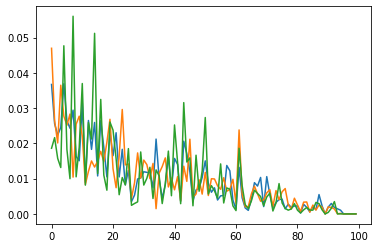

In [49]:
#across all timepoints
plt.plot(np.mean(male_syllable_expression_by_timepoint,axis=0)) #blue
plt.plot(np.mean(female_syllable_expression_by_timepoint,axis=0)) #orange
plt.plot(np.mean(ontogeny_syllable_expression_by_group,axis=0)) #green
plt.show()

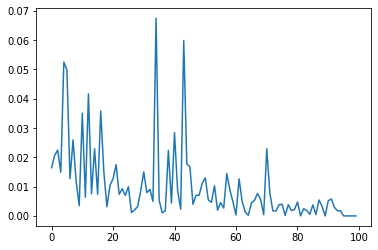

In [50]:
#at specific timepoint
t_point=42 #day 258!
plt.plot(male_syllable_expression_by_timepoint[t_point])
#plt.plot(female_syllable_expression_by_timepoint[t_point])
#plt.plot(ontogeny_syllable_expression_by_group[t_point])
plt.show()

In [51]:
#if the syllables need to be sorted by usage that can be done like so
alld = np.concatenate((np.concatenate(male_all_label_frequency_counts),np.concatenate(female_all_label_frequency_counts),np.concatenate(ontogeny_all_label_frequency_counts)))
sortbyusage_indices=np.argsort(np.mean(alld,axis=0))[::-1]

male_all_label_frequency_counts_sorted=[]
for i in range(len(male_all_label_frequency_counts)):
    freq_at_a_date=[]
    for ls in range(len(male_all_label_frequency_counts[i])):
        freq_at_a_date.append(male_all_label_frequency_counts[i][ls][sortbyusage_indices])
    male_all_label_frequency_counts_sorted.append(freq_at_a_date)

female_all_label_frequency_counts_sorted=[]
for i in range(len(female_all_label_frequency_counts)):
    freq_at_a_date=[]
    for ls in range(len(female_all_label_frequency_counts[i])):
        freq_at_a_date.append(female_all_label_frequency_counts[i][ls][sortbyusage_indices])
    female_all_label_frequency_counts_sorted.append(freq_at_a_date)

ontogeny_all_label_frequency_counts_sorted=[]
for i in range(len(ontogeny_all_label_frequency_counts)):
    freq_at_a_date=[]
    for ls in range(len(ontogeny_all_label_frequency_counts[i])):
        freq_at_a_date.append(ontogeny_all_label_frequency_counts[i][ls][sortbyusage_indices])
    ontogeny_all_label_frequency_counts_sorted.append(freq_at_a_date)

In [52]:
#change to probabilities #also decide if using sorted or not
use_post_hoc_sort=True

if use_post_hoc_sort:
    #male longtogeny
    for n in range(len(male_all_label_frequency_counts_sorted)):
        for j in range(len(male_all_label_frequency_counts_sorted[n])):
            male_all_label_frequency_counts_sorted[n][j]=male_all_label_frequency_counts_sorted[n][j]/sum(male_all_label_frequency_counts_sorted[n][j])

    male_frequencies=male_all_label_frequency_counts_sorted
    
    #female longtogeny
    for n in range(len(female_all_label_frequency_counts_sorted)):
        for j in range(len(female_all_label_frequency_counts_sorted[n])):
            female_all_label_frequency_counts_sorted[n][j]=female_all_label_frequency_counts_sorted[n][j]/sum(female_all_label_frequency_counts_sorted[n][j])

    female_frequencies=female_all_label_frequency_counts_sorted
    
    #ontogeny
    for n in range(len(ontogeny_all_label_frequency_counts_sorted)):
        for j in range(len(ontogeny_all_label_frequency_counts_sorted[n])):
            ontogeny_all_label_frequency_counts_sorted[n][j]=ontogeny_all_label_frequency_counts_sorted[n][j]/sum(ontogeny_all_label_frequency_counts_sorted[n][j])

    ontogeny_frequencies=ontogeny_all_label_frequency_counts_sorted

if not use_post_hoc_sort:
    #male longtogeny
    for n in range(len(male_all_label_frequency_counts)):
        for j in range(len(male_all_label_frequency_counts[n])):
            male_all_label_frequency_counts[n][j]=male_all_label_frequency_counts[n][j]/sum(male_all_label_frequency_counts[n][j])

    male_frequencies=male_all_label_frequency_counts
    #female longtogeny    
    for n in range(len(female_all_label_frequency_counts)):
        for j in range(len(female_all_label_frequency_counts[n])):
            female_all_label_frequency_counts[n][j]=female_all_label_frequency_counts[n][j]/sum(female_all_label_frequency_counts[n][j])

    female_frequencies=female_all_label_frequency_counts
    
    #ontogeny
    for n in range(len(ontogeny_all_label_frequency_counts)):
        for j in range(len(ontogeny_all_label_frequency_counts[n])):
            ontogeny_all_label_frequency_counts[n][j]=ontogeny_all_label_frequency_counts[n][j]/sum(ontogeny_all_label_frequency_counts[n][j])

    ontogeny_frequencies=ontogeny_all_label_frequency_counts

In [53]:
len(female_frequencies)

29

In [54]:
# find how many mice in each group and figure out that noise syllable is real
for indg,group in enumerate(ontogeny_frequencies):
    print(len(group))

22
22
22
22
19
20
19
19


In [55]:
# get a structure that holds the data per individuval mouse (len=16)
age_of_mouse_at_time_zero_in_days=24
male_individuals_frequencies=[]
male_individuals_associated_dates=[]
male_individuals_days=[]

for ui in unique_individual_longtogeny_males:
    a_mouse=[]
    a_date=[]
    a_day=[]
    for lsf in range(len(male_linear_sorted_fields)):
        if ui[0:2]==male_linear_sorted_fields[lsf][0] and ui[3:5]==male_linear_sorted_fields[lsf][1]:
            a_mouse.append(male_linear_sorted_frequencies[lsf]/sum(male_linear_sorted_frequencies[lsf]))
            a_date.append(male_linear_sorted_fields[lsf][2])
            d=int_to_datetime(male_linear_sorted_fields[lsf][2])-int_to_datetime(male_dates[0])
            a_day.append(str(d.days + age_of_mouse_at_time_zero_in_days))
    male_individuals_frequencies.append(a_mouse)
    male_individuals_associated_dates.append(a_date)
    male_individuals_days.append(a_day)

# for females
female_individuals_frequencies=[]
female_individuals_associated_dates=[]
female_individuals_days=[]

for ui in unique_individual_longtogeny_females:
    a_mouse=[]
    a_date=[]
    a_day=[]
    for lsf in range(len(female_linear_sorted_fields)):
        if ui[0:2]==female_linear_sorted_fields[lsf][0] and ui[3:5]==female_linear_sorted_fields[lsf][1]:
            a_mouse.append(female_linear_sorted_frequencies[lsf]/sum(female_linear_sorted_frequencies[lsf]))
            a_date.append(female_linear_sorted_fields[lsf][2])
            d=int_to_datetime(female_linear_sorted_fields[lsf][2])-int_to_datetime(female_dates[0])
            a_day.append(str(d.days + age_of_mouse_at_time_zero_in_days))
    female_individuals_frequencies.append(a_mouse)
    female_individuals_associated_dates.append(a_date)
    female_individuals_days.append(a_day)

In [56]:
# remove bad session 258 and 103 from male_frequencies
# from frequencies
bd = male_age_labels.index("258")
male_frequencies.pop(bd)
male_age_labels.pop(bd)
#from individual data
for i in range(len(male_individuals_frequencies)):
    if "258" in male_individuals_days[i]:
        ind=male_individuals_days[i].index("258")
        male_individuals_days[i].pop(ind)
        male_individuals_frequencies[i].pop(ind)
        
bd = male_age_labels.index("103")
male_frequencies.pop(bd)
male_age_labels.pop(bd)
#from individual data
for i in range(len(male_individuals_frequencies)):
    if "103" in male_individuals_days[i]:
        ind=male_individuals_days[i].index("103")
        male_individuals_days[i].pop(ind)
        male_individuals_frequencies[i].pop(ind)

## create a dataframe for data - with mouse number, cage number, time point, all syllables data

In [57]:
# for males
male_df=pd.DataFrame()
for i in range(len(male_individuals_frequencies)):
    #male_df=pd.DataFrame()
    a=male_individuals_frequencies[i]
    b=pd.DataFrame(a)
    b['mouse'] = str(i)
    b['time'] = male_individuals_days[i]
    b['cage'] = str(int(i/4))
    male_df = male_df.append(b)
male_df = male_df.reset_index(drop=True)

In [58]:
# for females
female_df=pd.DataFrame()
for i in range(len(female_individuals_frequencies)):
    a=female_individuals_frequencies[i]
    b=pd.DataFrame(a)
    b['mouse'] = str(i)
    b['time'] = female_individuals_days[i]
    b['cage'] = str(int(i/4))
    female_df = female_df.append(b)
female_df = female_df.reset_index(drop=True)

In [59]:
# for ontogeny
ontogeny_age_labels = ontogeny_groups
ontogeny_df=pd.DataFrame()
for i in range(len(ontogeny_frequencies)):
    a=ontogeny_frequencies[i]
    b=pd.DataFrame(a)
    b['mouse'] = list(range(len(a)))
    b['time'] = ontogeny_age_labels[i]
    ontogeny_df = ontogeny_df.append(b)
ontogeny_df = ontogeny_df.reset_index(drop=True)

In [60]:
# match males and females time points through interpolation
# arrange according to individual mice
from scipy.interpolate import interp1d
male_individuals_intr=[]
for ind, mouse in enumerate(male_individuals_frequencies):
    mouse_data=[]
    for inds in range(0,len(mouse[0])): #run though all data points of the mouse
        y=np.array(mouse)[:,inds] # get the probabilities of syllable x across all time points
        a=np.array(male_individuals_days[ind]) # get the days label for that mouse
        x = [int(i) for i in a] # turn days to integers
        f1 = interp1d(x, y, kind='linear') #interpolate the data
        xnew = np.array(range(min(x), max(x)+1)) #create a new days label with all the interpulated days
        ynew = f1(xnew) # intepolated data of syllable across timepoints
        mouse_data.append(ynew) # add the data about the syllable to the structure (syllable raws X timepoints columns)
    male_individuals_intr.append(np.transpose(mouse_data))

# arrange interpolated data according to time points (much like male_frequencies)
num_time=[]
male_frequencies_intr=[]
for ind, mouse in enumerate(male_individuals_intr): #find the max number of timepoints
    num_time.append(len(mouse))
num_time=max(num_time)
for indx in range(0,num_time):
    male_frequencies_intr.append([])
for ind, mouse in enumerate(male_individuals_intr): # for everymouse
    for indt, timep in enumerate(mouse): #for everytime point
        male_frequencies_intr[indt].append(timep)
male_intr_labels = np.array(range(0,num_time))+age_of_mouse_at_time_zero_in_days
male_intr_labels = [int(i) for i in male_intr_labels]

#for females
female_individuals_intr=[]
for ind, mouse in enumerate(female_individuals_frequencies):
    mouse_data=[]
    for inds in range(0,len(mouse[0])): #run though all data points of the mouse
        y=np.array(mouse)[:,inds] # get the probabilities of syllable x across all time points
        a=np.array(female_individuals_days[ind]) # get the days label for that mouse
        x = [int(i) for i in a] # turn days to integers
        f1 = interp1d(x, y, kind='linear') #interpolate the data
        xnew = np.array(range(min(x), max(x)+1)) #create a new days label with all the interpulated days
        ynew = f1(xnew) # intepolated data of syllable across timepoints
        mouse_data.append(ynew) # add the data about the syllable to the structure (syllable raws X timepoints columns)
    female_individuals_intr.append(np.transpose(mouse_data))

# arrange interpolated data according to time points (much like male_frequencies)
num_time=[]
female_frequencies_intr=[]
for ind, mouse in enumerate(female_individuals_intr): #find the max number of timepoints
    num_time.append(len(mouse))
num_time=max(num_time)
for indx in range(0,num_time):
    female_frequencies_intr.append([])
for ind, mouse in enumerate(female_individuals_intr): # for everymouse
    for indt, timep in enumerate(mouse): #for everytime point
        female_frequencies_intr[indt].append(timep)
female_intr_labels = np.array(range(0,num_time))+age_of_mouse_at_time_zero_in_days
female_intr_labels = [int(i) for i in female_intr_labels]

In [61]:
#based on the dates, create age labels that will be used for plots
age_of_mouse_at_time_zero_in_days=24
    
male_age_labels_int=[]
for n in male_age_labels:
    male_age_labels_int.append(int(n))
    
female_age_labels_int=[]
for n in female_age_labels:
    female_age_labels_int.append(int(n))

## create df for interpolated data

In [62]:
l = 356
# for males
male_intr_df=pd.DataFrame()
for i in range(len(male_individuals_intr)):
    a=male_individuals_intr[i]
    if len(a)==l:
        b=pd.DataFrame(a)
        b['mouse'] = str(i)
        b['time'] = male_intr_labels
        b['cage'] = str(int(i/4))
        male_intr_df = male_intr_df.append(b)
male_intr_df = male_intr_df.reset_index(drop=True)

In [63]:
l = 245
# for females
female_intr_df=pd.DataFrame()
for i in range(len(female_individuals_intr)):
    a=female_individuals_intr[i]
    if len(a)==l:
        b=pd.DataFrame(a)
        b['mouse'] = str(i)
        b['time'] = female_intr_labels
        b['cage'] = str(int(i/4))
        female_intr_df = female_intr_df.append(b)
female_intr_df = female_intr_df.reset_index(drop=True)

## df for interpolation for the data points we have

In [170]:
# prepare data
max_syll=40
data=male_df
data = data.drop(list(range(max_syll,100)), axis=1)
ind = data['time'].unique()
concat = {}
for m, _df in data.groupby('mouse'):
    _df=_df.drop_duplicates(subset=['time'])
    arr = _df.drop(columns=['mouse','cage']).set_index('time').reindex(ind).to_numpy().flatten()
    concat[m] = arr
concat = pd.DataFrame(concat).T

In [176]:
concat

,0,1,2,3,4,5,6,7,8,9,...,2070,2071,2072,2073,2074,2075,2076,2077,2078,2079
0,0.051988,0.036947,0.027495,0.037309,0.037420,0.029413,0.034167,0.005032,0.034807,0.023992,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.032359,0.036278,0.022184,0.030496,0.029829,0.024352,0.020627,0.005977,0.032470,0.028828,...,0.023532,0.018303,0.012267,0.007510,0.004284,0.021029,0.002698,0.046313,0.006203,0.016634
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.001196,0.012514,0.021803,0.003170,0.000946,0.022414,0.001530,0.008649,0.010623,0.007425
11,0.043301,0.033344,0.021970,0.019467,0.032204,0.048473,0.035180,0.005506,0.020913,0.005061,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,0.044618,0.028567,0.027288,0.041558,0.050264,0.061947,0.052907,0.006592,0.020195,0.007010,...,0.016327,0.021139,0.011487,0.005479,0.000139,0.013740,0.006759,0.012655,0.014519,0.000334
13,0.037138,0.033772,0.043369,0.042229,0.042173,0.030295,0.020419,0.006537,0.020808,0.047347,...,0.032707,0.001252,0.015908,0.006091,0.001530,0.013572,0.002058,0.013683,0.015296,0.005952
14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.015463,0.014796,0.029425,0.002586,0.000640,0.024780,0.006703,0.052620,0.014101,0.003838
15,0.064407,0.033622,0.031592,0.039573,0.038655,0.038460,0.037932,0.007898,0.028727,0.007564,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.054044,0.019576,0.013469,0.017680,0.020245,0.019381,0.042025,0.002956,0.028109,0.021305,...,0.017263,0.013733,0.010063,0.033887,0.002029,0.014427,0.008006,0.030134,0.005059,0.017152
3,0.025742,0.038752,0.025131,0.040393,0.043256,0.027799,0.025353,0.003336,0.030496,0.018014,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# ----------------------------------------------------------------------- 
# ANALYSIS
# -----------------------------------------------------------------------

In [64]:
# some important variables to remember:
# frequencies: ontogeny_frequencies, male_frequencies, female_frequencies (data points X individuals X syllables)
# labels for frequencies: ontogeny_age_labels, male_age_labels, female_age_labels (len = data points)
# as individuals: male_individuals_frequencies, male_individuals_associated_dates, male_individuals_days (data points X individuals X syllables) same for female)
# identify for individuals (labels): unique_individual_longtogeny_males (same for females)
# interpolated data frequencies: male_frequencies_intr, male_intr_labels (same for females)
# interpolated data individuals: male_individuals_intr
# data frames - female_df, male_df
# data frames for interpolated data - female_intr_df, male_intr_df

In [65]:
# plot/colors definitions
gep_color_mat=['limegreen', 'peru', 'silver']
from matplotlib.lines import Line2D
import matplotlib as mpl
ontogeny_age_labels = ontogeny_groups

# save figures
data_loc="/n/groups/datta/Dana/"+'ontogeny_figs_data/'
try:
    os.mkdir(data_loc)
except FileExistsError:
    # directory already exists
    pass

os.chdir(data_loc)

# umap for each data point - colored by individual

In [66]:
import warnings

# Normalization

def zscore(data, axis=0, eps=1e-10):
    """
    Z-score standardize the data along ``axis``
    """
    mean = np.mean(data, axis=axis, keepdims=True)
    std = np.std(data, axis=axis, keepdims=True) + eps
    return (data-mean)/std

# Dimensionality reduction

def umap_embedding(
    data, 
    standardize=True,
    n_pcs=20, 
    n_components=2, 
    n_neighbors=100,
    random_state=42,
    **kwargs
):
    """Generate a 2D embedding of neural activity using UMAP. The function 
    generates the embedding in three steps:
        1. (Optionally) standardize (Z-score) the activity of each neuron
        2. Perform initial dimensionality reduction using PCA
        3. Run UMAP on the output of PCA
    Parameters
    ----------
    data: ndarray
        Array of neural activity where rows are neurons and columns are time points
    standardize: bool, default=True
        Whether to standardize (Z-score) the data prior to PCA
    n_pcs: int, default=20
        Number of principal components to use during PCA. If ``n_pcs=None``, the binned 
        data will be passed directly to UMAP
    n_components: int, default=2
        Dimensionality of the embedding
    n_neighbors: int, default=100
        Passed to UMAP (see `explanation of UMAP parameters <https://umap-learn.readthedocs.io/en/latest/parameters.html>`_).
    **kwargs
        Any other UMAP parameters can also be passed as keyword arguments
    Returns
    -------
    coodinates: ndarray
        (N,2) array containing UMAP coordinates
    """
    from sklearn.decomposition import PCA
    from umap import UMAP

    if standardize: data = zscore(data, axis=1)
    PCs = PCA(n_components=n_pcs).fit_transform(data.T)
    umap_obj = UMAP(n_neighbors=n_neighbors, n_components=n_components, n_epochs=500,random_state=random_state,**kwargs)
    coordinates = umap_obj.fit_transform(PCs)
    return coordinates

# for males

In [67]:
# prepare data
max_syll=40
data = female_df.drop(list(range(max_syll,100)), axis=1)
data_umap = data.drop(['mouse','time','cage'], axis=1).to_numpy()
data_umap_labels = data['time'].to_numpy()

In [68]:
# transform indv mice to labels
from sklearn.preprocessing import StandardScaler, LabelEncoder
exp = sorted(data.time.unique())
le = LabelEncoder()
le.fit(exp)
y = le.transform(data_umap_labels)

In [69]:
# sort frequencies by mouse
coordinates = umap_embedding(data_umap.T, 
        standardize=True,
        n_pcs=None, 
        n_components=2, 
        n_neighbors=10,
        random_state=0)

In [1]:
# variables to plot
import colorcet as cc
cmap2 = cc.glasbey

custom_lines=[]
for i in range(len(exp)):
    custom_lines.append(Line2D([0], [0], color=cmap2[i], lw=4))
    
fig, ax = plt.subplots()
fig.set_size_inches(10,10) 
plt.legend(handles=custom_lines,labels=list(exp),bbox_to_anchor=(1.2, 1))
plt.title('Umap colored by days',fontsize=20)
ax.set_xticks([])
ax.set_yticks([])
fig.patch.set_facecolor('white')
    
for i in range(len(coordinates)):
    plt.scatter(coordinates[i][0],coordinates[i][1],color=custom_lines[y[i]].get_color(), s=50)
#fig.savefig(data_loc + 'umap_indv.pdf', bbox_inches='tight')

NameError: name 'exp' is not defined

# TSNE and PCA males

In [71]:
import time
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [72]:
# prepare data
max_syll=40
data = male_intr_df
data = data.drop(list(range(max_syll,100)), axis=1)
data_umap = data.drop(['mouse','time','cage'], axis=1).to_numpy()
data_umap_labels = data['time'].to_numpy()

In [73]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(data_umap)
df_subset = pd.DataFrame()
df_subset['pca-one'] = pca_result[:,0]
df_subset['pca-two'] = pca_result[:,1] 
df_subset['pca-three'] = pca_result[:,2]

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.39559082 0.20607464 0.09829612]


In [74]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(data_umap)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
df_subset['label'] = data_umap_labels

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 4628 samples in 0.001s...


/home/drl21/miniconda/envs/moseq2/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/drl21/miniconda/envs/moseq2/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 4628 samples in 0.658s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4628
[t-SNE] Computed conditional probabilities for sample 2000 / 4628
[t-SNE] Computed conditional probabilities for sample 3000 / 4628
[t-SNE] Computed conditional probabilities for sample 4000 / 4628
[t-SNE] Computed conditional probabilities for sample 4628 / 4628
[t-SNE] Mean sigma: 0.022378
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.907166
[t-SNE] KL divergence after 300 iterations: 1.318193
t-SNE done! Time elapsed: 3.924560785293579 seconds


# plot PCA

/home/drl21/miniconda/envs/moseq2/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: 
The palette list has fewer values (350) than needed (356) and will cycle, which may produce an uninterpretable plot.
  if __name__ == '__main__':


Text(0.5, 1.0, 'PCA male time')

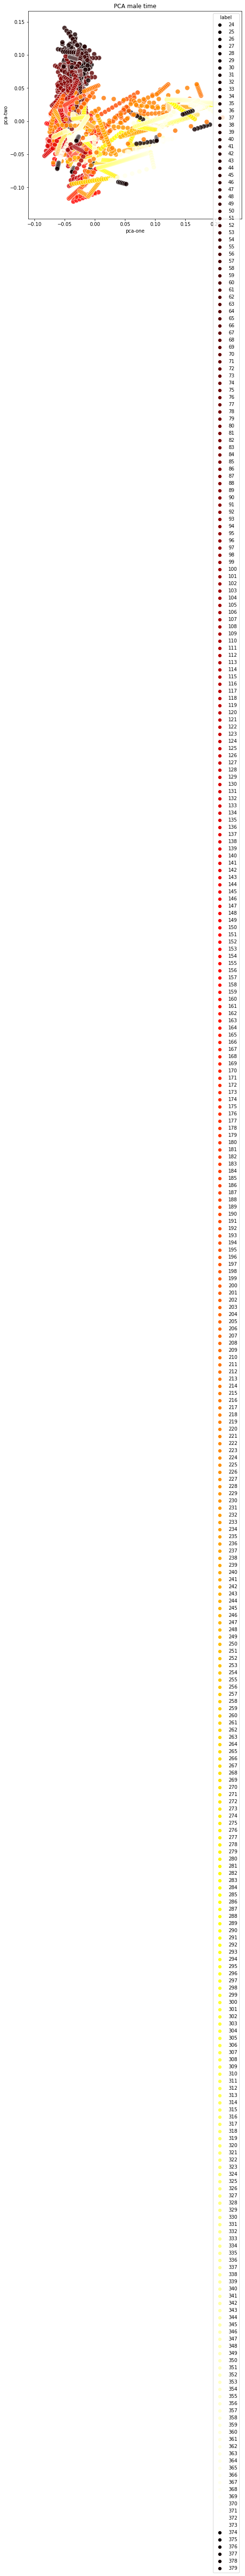

In [75]:
plt.figure(figsize=(8,8))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="label",
    palette=sns.color_palette('hot',350),
    data=df_subset,
    s=100,
    #legend="full",
    alpha=0.8)
plt.title ('PCA male time')

## PLOT TSNE

/home/drl21/miniconda/envs/moseq2/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: 
The palette list has fewer values (350) than needed (356) and will cycle, which may produce an uninterpretable plot.
  if __name__ == '__main__':


Text(0.5, 1.0, 'tsne male time')

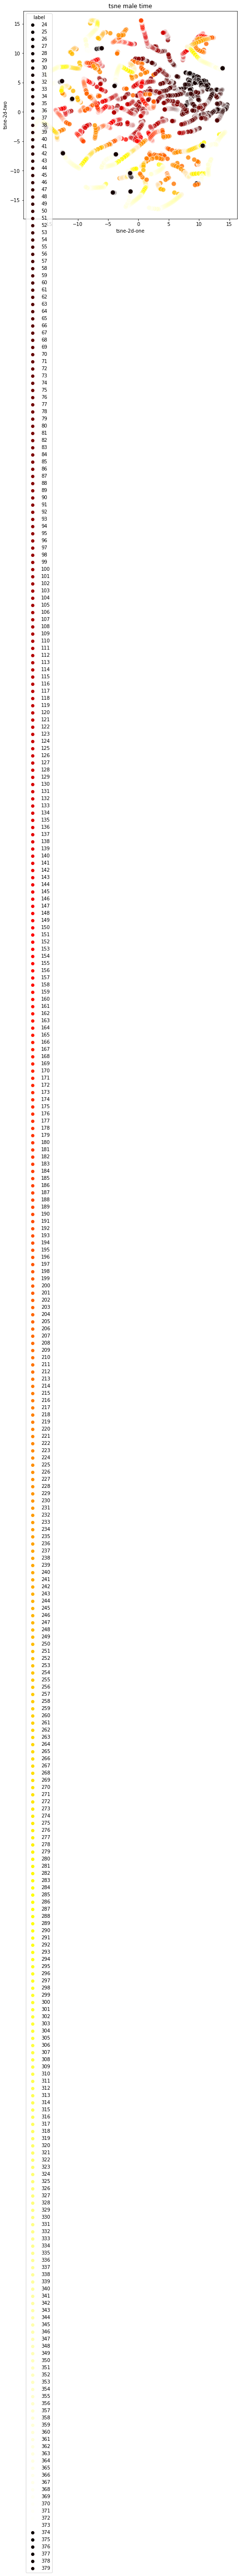

In [76]:
plt.figure(figsize=(8,8))
sns.scatterplot(
    x='tsne-2d-one', y='tsne-2d-two',
    hue="label",
    palette=sns.color_palette('hot',350),
    data=df_subset,
    s=100,
    legend="full",
    alpha=0.8)
plt.title ('tsne male time')

In [77]:
##########

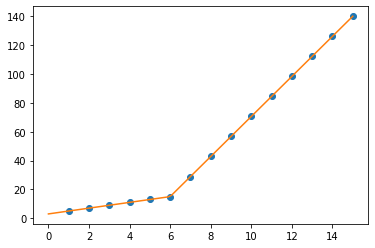

In [78]:
from scipy import optimize
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

x = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10 ,11, 12, 13, 14, 15], dtype=float)
y = np.array([5, 7, 9, 11, 13, 15, 28.92, 42.81, 56.7, 70.59, 84.47, 98.36, 112.25, 126.14, 140.03])

def piecewise_linear(x, x0, y0, k1, k2):
    return np.piecewise(x, [x < x0], [lambda x:k1*x + y0-k1*x0, lambda x:k2*x + y0-k2*x0])

p , e = optimize.curve_fit(piecewise_linear, x, y)
xd = np.linspace(0, 15, 100)
plt.plot(x, y, "o")
plt.plot(xd, piecewise_linear(xd, *p))

# PCA loadings ontogeny data

In [79]:
# prepare data
max_syll=40
max_mice = 24
data = female_intr_df
data = data.drop(list(range(max_syll,100)), axis=1)
#index = _df['time'].to_numpy()
ind = data['time'].unique()
concat = {}
for m, _df in data.groupby('mouse'):
    arr = _df.drop(columns=['mouse','cage']).set_index('time').reindex(ind).to_numpy().flatten()
    concat[m] = arr
concat = pd.DataFrame(concat).T
data_pca = concat[:max_mice]

In [80]:
# prepare data
# apply PCA
pca = PCA(n_components=2)
pca.fit_transform(data_pca)

loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'])
loadings['syll'] = list(range(max_syll)) * len(ind)
loadings['time'] = list(np.repeat(ind, max_syll))

Text(0.5, 1.0, 'syllable loads pc1')

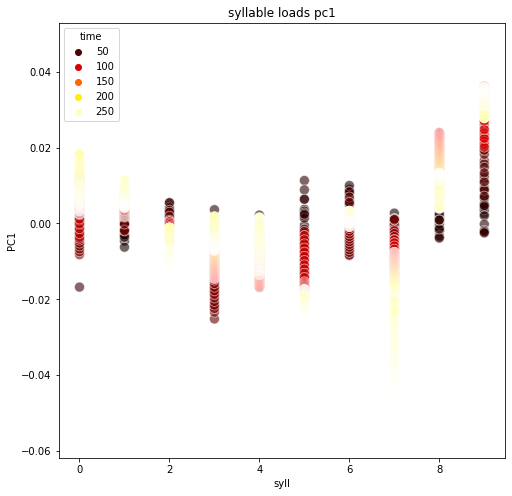

In [81]:
nsyll=10
to_plot = loadings[loadings.syll<nsyll]
plt.figure(figsize=(8,8))
sns.scatterplot(data=to_plot, y='PC1', x='syll', hue='time', palette="hot", s=100, alpha=0.60)
plt.title('syllable loads pc1')

Text(0.5, 1.0, 'syllable loads pc2')

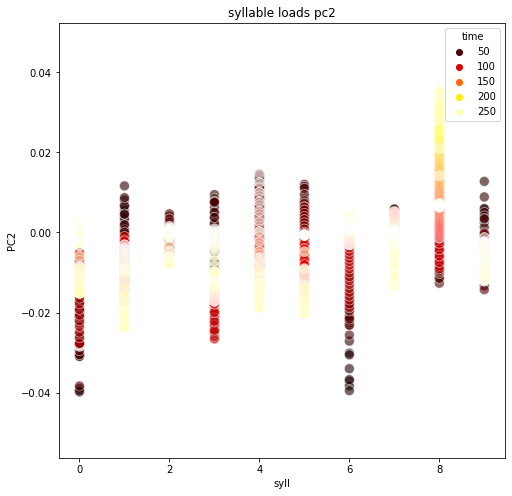

In [82]:
to_plot = loadings[loadings.syll<nsyll]
plt.figure(figsize=(8,8))
sns.scatterplot(data=to_plot, y='PC2', x='syll', hue='time', palette="hot", s=100, alpha=0.60)
plt.title('syllable loads pc2')

Text(0.5, 1, 'syllable loadings on PC1 male interpolated data')

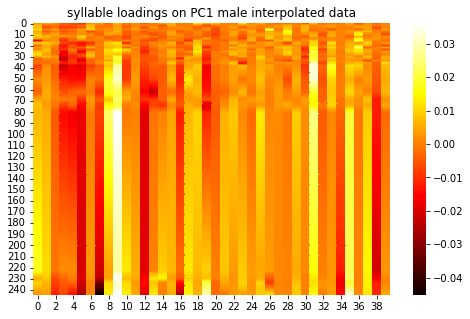

In [83]:
plt.figure(figsize=(8,5))
pc1= loadings.PC1.to_numpy().reshape(-1,max_syll)
ax=sns.heatmap(pc1, cmap="hot")
plt.title ('syllable loadings on PC1 male interpolated data')

Text(0.5, 1, 'syllable loadings on PC2 male interpolated data')

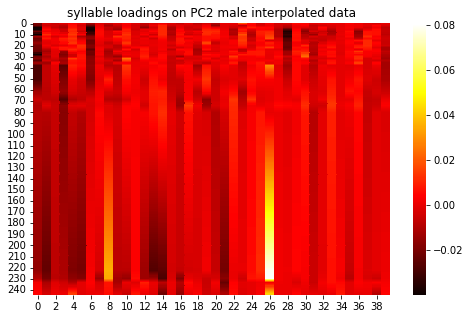

In [84]:
plt.figure(figsize=(8,5))
pc1= loadings.PC2.to_numpy().reshape(-1,max_syll)
ax=sns.heatmap(pc1, cmap="hot")
plt.title ('syllable loadings on PC2 male interpolated data')

## PCA projections of the same individual - concatenated datapoints

In [85]:
# prepare data
max_syll=40
#max_mice = 19
data=male_intr_df
data = data.drop(list(range(max_syll,100)), axis=1)
#index = _df['time'].to_numpy()
ind = data['time'].unique()
concat = {}
for m, _df in data.groupby('mouse'):
    _df=_df.drop_duplicates(subset=['time'])
    arr = _df.drop(columns=['mouse','cage']).set_index('time').reindex(ind).to_numpy().flatten()
    concat[m] = arr
concat = pd.DataFrame(concat).T

In [86]:
## interpolating the data using mean across columns
data_pca = concat.to_numpy()
#from sklearn.impute import SimpleImputer
#imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
#data_pca=imp_mean.fit_transform(data_pca)

In [87]:
## apply pca
pca = PCA(n_components=3)
pca_result = pca.fit_transform(data_pca)
df_subset = pd.DataFrame()
df_subset['pca-one'] = pca_result[:,0]
df_subset['pca-two'] = pca_result[:,1] 
df_subset['pca-three'] = pca_result[:,2]
df_subset['labels'] = list(range(len(df_subset)))

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.42775746 0.16010783 0.09482483]


/home/drl21/miniconda/envs/moseq2/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: The palette list has more values (20) than needed (13), which may not be intended.
  if __name__ == '__main__':


Text(0.5, 1.0, 'PCA for each individual across the trajectory - female')

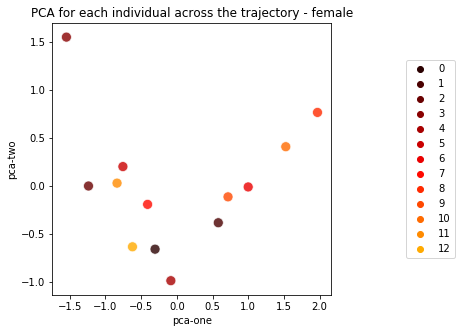

In [88]:
plt.figure(figsize=(5,5))
g=sns.scatterplot(
    x="pca-one", y="pca-two",
    palette=sns.color_palette('hot',20),
    data=df_subset,
    s=100,
    legend="full",
    hue = 'labels',
    alpha=0.8)
g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
plt.title('PCA for each individual across the trajectory - female')

In [89]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(data_pca)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]

[t-SNE] Computing 12 nearest neighbors...
[t-SNE] Indexed 13 samples in 0.000s...
[t-SNE] Computed neighbors for 13 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 13 / 13
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.754253
[t-SNE] KL divergence after 300 iterations: 0.640855
t-SNE done! Time elapsed: 0.06244397163391113 seconds


/home/drl21/miniconda/envs/moseq2/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/drl21/miniconda/envs/moseq2/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


/home/drl21/miniconda/envs/moseq2/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: The palette list has more values (20) than needed (13), which may not be intended.
  if __name__ == '__main__':


Text(0.5, 1.0, 'tsne for each individual across the trajectory - female')

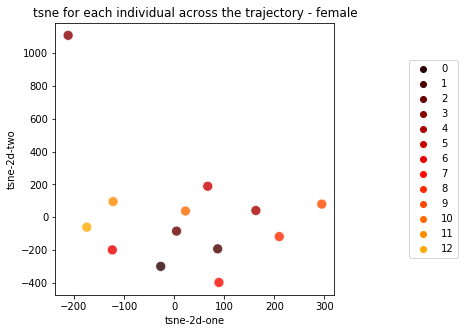

In [90]:
plt.figure(figsize=(5,5))
g=sns.scatterplot(
    x='tsne-2d-one', y='tsne-2d-two',
    palette=sns.color_palette('hot',20),
    data=df_subset,
    s=100,
    legend="full",
    hue='labels',
    alpha=0.8)
g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
plt.title('tsne for each individual across the trajectory - female')

# KLD between individuals

In [91]:
def KLD_analysis(frequencies):
    '''rows are sessions (or mice/phases), columns are variables (syllables)'''
    cohort_dist=np.zeros((len(frequencies),len(frequencies)),dtype=float)
    x=0
    y=0
    for i in frequencies:
        for j in frequencies:
            i[i==0]=.0000000001
            j[j==0]=.0000000001
            cohort_dist[x,y]=scipy.stats.entropy(pk=np.array(i), qk=np.array(j))
            y=y+1
        y=0
        x=x+1
    return cohort_dist

def plot_KLD(cohort_dist,age_labels,name,vmax=1):
    # cohort_dist is matrix of
    seqmatcolor='Purples_r'
    cmg=sns.clustermap(cohort_dist,cmap=seqmatcolor,xticklabels=1,yticklabels=1,
                   colors_ratio=0.2,cbar_pos=(0.99, 0.045, 0.03, .70),
                   col_cluster=False,row_cluster=False,
                   method='average',metric='sqeuclidean', vmax=vmax)
    cmg.fig.set_size_inches(10,10)
    ax = cmg.ax_heatmap
    ax.set_xticklabels(age_labels)
    ax.set_yticklabels(age_labels)
    ax.set_title('Syllable Usage based KLD distance',fontsize=20)
    plt.show()

In [164]:
# KLD between mice for each data point 
# prepare data
max_syll=40
data=male_intr_df
data = data.drop(list(range(max_syll,100)), axis=1)
#index = _df['time'].to_numpy()
ind = data['time'].unique()
mm=[]
kld_time=[]
kld_mat=[]
kld_time_temp=[]
for t in ind:
    mean_df_lc = data[data.time==t] 
    mm=mean_df_lc.drop(['mouse','time','cage'], axis=1).to_numpy()
    kld = KLD_analysis(mm)
    kld_mat.append(kld)
    kld_time_temp.append(kld.flatten())

kld_time = pd.DataFrame(np.array(kld_time_temp).flatten(), columns=['kld'])
kld_time['time'] = list(np.repeat(ind, len((kld_time_temp[0]))))

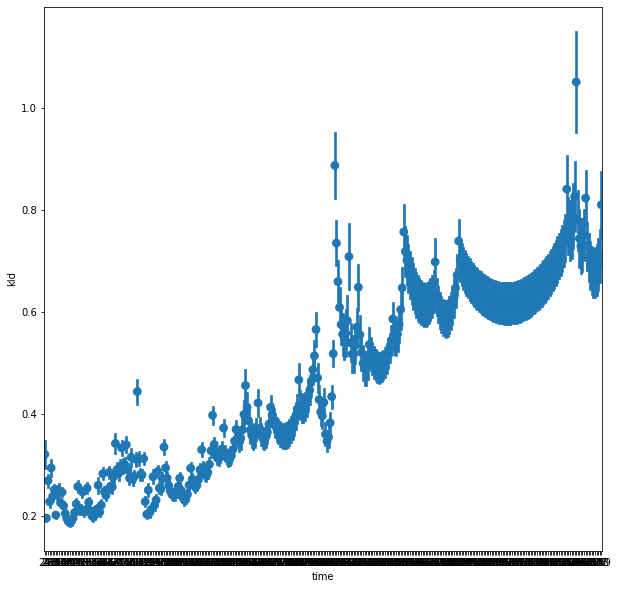

In [166]:
kld_time.replace(0, np.nan, inplace=True)
kld_time.replace([np.inf, -np.inf], np.nan, inplace=True)


plt.figure(figsize=(10,10))
sns.pointplot(data=kld_time, x='time',y='kld',errorbar='se',join=False)

t:  44%|████▍     | 106/240 [02:06<00:10, 13.32it/s, now=None]

Moviepy - Building video /n/groups/datta/Dana/ontogeny_figs_data/kld_indv_female.mp4.
Moviepy - Writing video /n/groups/datta/Dana/ontogeny_figs_data/kld_indv_female.mp4




t:  44%|████▍     | 106/240 [02:27<00:10, 13.32it/s, now=None]

Moviepy - Done !
Moviepy - video ready /n/groups/datta/Dana/ontogeny_figs_data/kld_indv_female.mp4


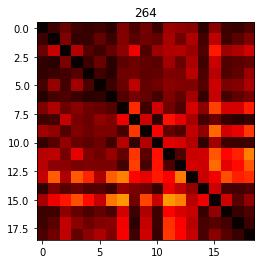

In [133]:
# importing movie py libraries
from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage
from IPython import display
 
# numpy array
x = np.linspace(-2, 2, 200)
 
# duration of the video
fps=10
duration = int(np.floor(len(kld_mat)/fps))
 
# matplot subplot
fig, ax = plt.subplots() 
# method to get frames
i=0
def make_frame(t):
    global i
    global ind
    # clear
    ax.clear()
    # plotting line
    ax.imshow(kld_mat[i],cmap='hot', vmax=1.5)
    plt.title(ind[i])
    i=i+1
    # returning numpy image
    return mplfig_to_npimage(fig)
 
# creating animation
animation = VideoClip(make_frame, duration = duration)
animation.write_videofile(data_loc+"kld_indv_female.mp4",fps=fps)
# displaying animation with auto play and looping
#animation.ipython_display(fps = fps, loop = False, autoplay = False)


In [135]:
kld_time.replace(0, np.NaN)
plt.figure(figsize=(8,8))
sns.pointplot(
    data=kld_time,
    x='time', y='tsne-2d-two',
    hue="label",
    palette=sns.color_palette('hot',350),
    
    s=100,
    legend="full",
    alpha=0.8)
plt.title ('tsne male time')

,0,1,2,3,4,5,6,7,8,9,...,352,353,354,355,356,357,358,359,360,time
0,NaN,0.154483,0.067682,0.261570,0.227664,0.148619,0.106289,0.111998,0.134092,0.105840,...,0.140589,0.154771,0.159387,0.205403,0.173914,0.132688,0.124714,0.237538,NaN,24
1,NaN,0.122779,0.061738,0.173573,0.198243,0.093104,0.128973,0.082068,0.090789,0.090650,...,0.081257,0.108074,0.090716,0.103616,0.099589,0.086158,0.048616,0.150857,NaN,25
2,NaN,0.222825,0.158326,0.228783,0.376091,0.181738,0.311316,0.140782,0.145558,0.175839,...,0.080824,0.149103,0.103745,0.089447,0.118311,0.088323,0.085602,0.170116,NaN,26
3,NaN,0.108602,0.152523,0.186150,0.241168,0.150362,0.175780,0.103773,0.111029,0.172310,...,0.071293,0.160176,0.096645,0.075920,0.126193,0.067633,0.068062,0.132162,NaN,27
4,NaN,0.138892,0.236230,0.284939,0.184460,0.228511,0.236785,0.145311,0.294955,0.258259,...,0.109140,0.233371,0.202161,0.108630,0.214260,0.135418,0.102744,0.150297,NaN,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240,NaN,0.115828,0.213213,0.118048,0.095427,0.121287,0.081060,0.259649,0.148445,0.236369,...,0.108102,0.669018,0.552468,0.416433,0.143673,0.281384,0.170449,0.107102,NaN,264
241,NaN,0.111053,0.228996,0.125841,0.099373,0.124647,0.079269,0.275436,0.148354,0.250023,...,0.115070,0.680373,0.580747,0.465900,0.144437,0.290327,0.187714,0.120562,NaN,265
242,NaN,0.108969,0.249407,0.136265,0.105914,0.131136,0.080055,0.294461,0.152544,0.266583,...,0.126675,0.694356,0.615221,0.521646,0.147092,0.301602,0.208370,0.136329,NaN,266
243,NaN,0.109635,0.274845,0.150111,0.115219,0.140637,0.083504,0.316775,0.162484,0.286212,...,0.143027,0.713395,0.656538,0.584881,0.151685,0.315451,0.232443,0.154771,NaN,267


## Cage decoder

In [102]:
import pandas as pd
import numpy as np
import warnings
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupKFold, LeaveOneGroupOut, LeaveOneOut
from sklearn.metrics import accuracy_score
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
from sklearn.preprocessing import LabelEncoder
from sklearn import datasets
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from collections import defaultdict
from sklearn.model_selection import cross_val_score
from random import sample

In [103]:
## select only time points in which all mice from a cage are included

In [112]:
df=male_df.copy()
df = df.astype({'time':'int'})

minm = 3 # find time points and cages with at least 3 mice per cage
minc=4 # find time points with at least 4 cages

ind=[]
for t in sorted(df.time.unique()):
    curr_df = df[df.time==t] # get data for current time point
    mouse_count = curr_df.groupby('cage')['mouse'].nunique() # find number of mice in each cage
    cages = list(mouse_count[mouse_count >= minm].index) # find cages with more than 3 mice
    if len(cages) >= minc: # make sure there are a minimum number of cages in this time point that have minumum mice
        ind.append(list(curr_df[curr_df.cage.isin(cages)].index)) # save appropriate data indices
ind = np.concatenate(ind)
data = df.loc[ind]

In [116]:
from tqdm import tqdm

# set decoder params
warnings.simplefilter('ignore')
cv = LeaveOneOut()
clf = RandomForestClassifier(n_estimators = 100,class_weight='balanced')
#clf = LinearSVC()
#clf = LogisticRegression(class_weight='balanced',solver='lbfgs',multi_class='ovr',max_iter=1000)
it=2
scores=[]
shuff_scores=[]
for t in sorted(data.time.unique()):
    data2=data[data.time==t]
    X=data2.drop(['mouse','cage','time'], axis=1).to_numpy()
    #X = np.log(X + 1e-6) # convert to linear
    y = data2.cage.to_numpy()
    scores.append(np.mean(cross_val_score(clf, X, y, scoring='accuracy',cv=cv)))
    sc=[]
    for i in tqdm(range(it)):
        shuff_y = np.random.permutation(y)
        print(y)
        print(shuff_y)
        sc.append(np.mean(cross_val_score(clf, X, shuff_y, scoring='accuracy',cv=cv)))
    shuff_scores.append(sc)

  0%|          | 0/2 [00:00<?, ?it/s]

['0' '0' '0' '0' '1' '1' '1' '2' '2' '2' '3' '3' '3']
['3' '2' '0' '0' '2' '1' '1' '0' '2' '1' '0' '3' '3']


 50%|█████     | 1/2 [00:01<00:01,  1.95s/it]

['0' '0' '0' '0' '1' '1' '1' '2' '2' '2' '3' '3' '3']
['1' '0' '1' '3' '3' '1' '3' '0' '0' '0' '2' '2' '2']


  0%|          | 0/2 [00:00<?, ?it/s]

['0' '0' '0' '1' '1' '1' '2' '2' '2' '2' '3' '3' '3']
['2' '1' '1' '0' '1' '2' '3' '2' '2' '0' '3' '3' '0']


 50%|█████     | 1/2 [00:02<00:02,  2.06s/it]

['0' '0' '0' '1' '1' '1' '2' '2' '2' '2' '3' '3' '3']
['0' '1' '1' '0' '3' '2' '0' '3' '2' '2' '3' '2' '1']


  0%|          | 0/2 [00:00<?, ?it/s]

['0' '0' '0' '1' '1' '1' '2' '2' '2' '3' '3' '3']
['2' '3' '2' '1' '2' '3' '1' '3' '0' '0' '1' '0']


 50%|█████     | 1/2 [00:01<00:01,  1.80s/it]

['0' '0' '0' '1' '1' '1' '2' '2' '2' '3' '3' '3']
['3' '2' '0' '0' '0' '2' '3' '1' '1' '2' '1' '3']


  0%|          | 0/2 [00:00<?, ?it/s]

['0' '0' '0' '1' '1' '1' '2' '2' '2' '3' '3' '3']
['1' '3' '1' '3' '0' '1' '2' '2' '3' '2' '0' '0']


 50%|█████     | 1/2 [00:01<00:01,  1.80s/it]

['0' '0' '0' '1' '1' '1' '2' '2' '2' '3' '3' '3']
['0' '0' '1' '3' '3' '1' '2' '3' '0' '2' '2' '1']


  0%|          | 0/2 [00:00<?, ?it/s]

['0' '0' '0' '1' '1' '1' '2' '2' '2' '3' '3' '3']
['1' '3' '2' '1' '2' '0' '1' '3' '0' '0' '3' '2']


 50%|█████     | 1/2 [00:01<00:01,  1.80s/it]

['0' '0' '0' '1' '1' '1' '2' '2' '2' '3' '3' '3']
['3' '3' '3' '1' '2' '2' '0' '1' '1' '2' '0' '0']


  0%|          | 0/2 [00:00<?, ?it/s]

['0' '0' '0' '1' '1' '1' '2' '2' '2' '3' '3' '3']
['0' '1' '0' '2' '2' '0' '3' '3' '3' '1' '1' '2']


 50%|█████     | 1/2 [00:01<00:01,  1.80s/it]

['0' '0' '0' '1' '1' '1' '2' '2' '2' '3' '3' '3']
['3' '0' '0' '2' '1' '1' '3' '1' '0' '2' '2' '3']


  0%|          | 0/2 [00:00<?, ?it/s]

['0' '0' '0' '1' '1' '1' '2' '2' '2' '3' '3' '3']
['1' '2' '2' '3' '3' '1' '0' '0' '3' '1' '0' '2']


 50%|█████     | 1/2 [00:01<00:01,  1.81s/it]

['0' '0' '0' '1' '1' '1' '2' '2' '2' '3' '3' '3']
['1' '0' '2' '3' '3' '3' '0' '1' '0' '2' '2' '1']


  0%|          | 0/2 [00:00<?, ?it/s]

['0' '0' '0' '1' '1' '1' '2' '2' '2' '3' '3' '3']
['1' '1' '2' '3' '3' '1' '3' '2' '0' '2' '0' '0']


 50%|█████     | 1/2 [00:01<00:01,  1.81s/it]

['0' '0' '0' '1' '1' '1' '2' '2' '2' '3' '3' '3']
['0' '2' '3' '1' '2' '0' '0' '3' '2' '1' '3' '1']


  0%|          | 0/2 [00:00<?, ?it/s]

['0' '0' '0' '1' '1' '1' '2' '2' '2' '3' '3' '3' '3']
['0' '0' '3' '3' '2' '3' '1' '0' '1' '3' '2' '1' '2']


 50%|█████     | 1/2 [00:01<00:01,  1.95s/it]

['0' '0' '0' '1' '1' '1' '2' '2' '2' '3' '3' '3' '3']
['1' '2' '1' '0' '2' '0' '3' '3' '0' '2' '3' '3' '1']


  0%|          | 0/2 [00:00<?, ?it/s]

['0' '0' '0' '1' '1' '1' '2' '2' '2' '2' '3' '3' '3' '3']
['1' '1' '2' '0' '0' '3' '2' '3' '3' '2' '0' '3' '1' '2']


 50%|█████     | 1/2 [00:02<00:02,  2.10s/it]

['0' '0' '0' '1' '1' '1' '2' '2' '2' '2' '3' '3' '3' '3']
['2' '1' '3' '2' '1' '3' '2' '2' '3' '0' '0' '0' '1' '3']


  0%|          | 0/2 [00:00<?, ?it/s]

['0' '0' '0' '1' '1' '1' '1' '2' '2' '2' '3' '3' '3' '3']
['1' '1' '3' '1' '2' '0' '3' '1' '2' '0' '3' '2' '0' '3']


 50%|█████     | 1/2 [00:02<00:02,  2.11s/it]

['0' '0' '0' '1' '1' '1' '1' '2' '2' '2' '3' '3' '3' '3']
['3' '2' '1' '1' '2' '3' '1' '0' '0' '1' '3' '0' '3' '2']


  0%|          | 0/2 [00:00<?, ?it/s]

['0' '0' '0' '0' '1' '1' '1' '2' '2' '2' '2' '3' '3' '3' '3']
['2' '3' '2' '0' '0' '0' '2' '2' '3' '0' '3' '1' '1' '1' '3']


 50%|█████     | 1/2 [00:02<00:02,  2.26s/it]

['0' '0' '0' '0' '1' '1' '1' '2' '2' '2' '2' '3' '3' '3' '3']
['2' '1' '0' '1' '3' '2' '0' '0' '3' '0' '2' '3' '1' '2' '3']


  0%|          | 0/2 [00:00<?, ?it/s]

['0' '0' '0' '1' '1' '1' '2' '2' '2' '3' '3' '3']
['3' '0' '1' '1' '2' '0' '2' '3' '2' '1' '3' '0']


 50%|█████     | 1/2 [00:01<00:01,  1.80s/it]

['0' '0' '0' '1' '1' '1' '2' '2' '2' '3' '3' '3']
['2' '0' '0' '3' '2' '1' '2' '3' '1' '0' '3' '1']


  0%|          | 0/2 [00:00<?, ?it/s]

['0' '0' '0' '0' '1' '1' '1' '1' '2' '2' '2' '2' '3' '3' '3' '3']
['3' '1' '0' '0' '3' '1' '3' '0' '0' '2' '1' '3' '1' '2' '2' '2']


 50%|█████     | 1/2 [00:02<00:02,  2.41s/it]

['0' '0' '0' '0' '1' '1' '1' '1' '2' '2' '2' '2' '3' '3' '3' '3']
['3' '0' '3' '3' '1' '1' '0' '3' '2' '1' '0' '2' '2' '0' '1' '2']


  0%|          | 0/2 [00:00<?, ?it/s]

['0' '0' '0' '0' '1' '1' '1' '1' '2' '2' '2' '2' '3' '3' '3' '3']
['3' '1' '1' '2' '2' '2' '0' '0' '3' '2' '1' '3' '0' '3' '1' '0']


 50%|█████     | 1/2 [00:02<00:02,  2.41s/it]

['0' '0' '0' '0' '1' '1' '1' '1' '2' '2' '2' '2' '3' '3' '3' '3']
['3' '3' '2' '0' '1' '1' '0' '2' '1' '3' '2' '0' '0' '2' '3' '1']


  0%|          | 0/2 [00:00<?, ?it/s]

['0' '0' '0' '0' '1' '1' '1' '1' '2' '2' '2' '2' '3' '3' '3' '3']
['2' '2' '1' '0' '2' '1' '3' '3' '0' '1' '0' '0' '3' '2' '3' '1']


 50%|█████     | 1/2 [00:02<00:02,  2.36s/it]

['0' '0' '0' '0' '1' '1' '1' '1' '2' '2' '2' '2' '3' '3' '3' '3']
['2' '3' '3' '0' '3' '1' '1' '0' '0' '2' '0' '3' '2' '1' '2' '1']


  0%|          | 0/2 [00:00<?, ?it/s]

['0' '0' '0' '0' '1' '1' '1' '1' '2' '2' '2' '2' '3' '3' '3' '3']
['3' '1' '0' '2' '1' '2' '0' '2' '3' '3' '0' '3' '1' '1' '0' '2']


 50%|█████     | 1/2 [00:02<00:02,  2.37s/it]

['0' '0' '0' '0' '1' '1' '1' '1' '2' '2' '2' '2' '3' '3' '3' '3']
['2' '2' '3' '1' '3' '0' '2' '1' '2' '3' '1' '0' '0' '1' '0' '3']


  0%|          | 0/2 [00:00<?, ?it/s]

['0' '0' '0' '1' '1' '1' '1' '2' '2' '2' '2' '3' '3' '3' '3']
['0' '2' '0' '2' '0' '3' '3' '1' '3' '2' '3' '2' '1' '1' '1']


 50%|█████     | 1/2 [00:02<00:02,  2.21s/it]

['0' '0' '0' '1' '1' '1' '1' '2' '2' '2' '2' '3' '3' '3' '3']
['1' '1' '3' '0' '1' '2' '0' '0' '3' '1' '2' '3' '2' '3' '2']


  0%|          | 0/2 [00:00<?, ?it/s]

['0' '0' '0' '0' '1' '1' '1' '2' '2' '2' '3' '3' '3' '3']
['0' '2' '1' '0' '3' '0' '2' '1' '1' '3' '0' '3' '2' '3']


 50%|█████     | 1/2 [00:02<00:02,  2.06s/it]

['0' '0' '0' '0' '1' '1' '1' '2' '2' '2' '3' '3' '3' '3']
['0' '2' '0' '3' '1' '0' '1' '2' '3' '1' '2' '0' '3' '3']


  0%|          | 0/2 [00:00<?, ?it/s]

['0' '0' '0' '0' '1' '1' '1' '1' '2' '2' '2' '2' '3' '3' '3']
['3' '2' '3' '0' '2' '1' '0' '0' '2' '0' '1' '2' '1' '1' '3']


 50%|█████     | 1/2 [00:02<00:02,  2.21s/it]

['0' '0' '0' '0' '1' '1' '1' '1' '2' '2' '2' '2' '3' '3' '3']
['0' '3' '3' '3' '0' '2' '1' '1' '2' '1' '0' '0' '2' '1' '2']


  0%|          | 0/2 [00:00<?, ?it/s]

['0' '0' '0' '0' '1' '1' '1' '1' '2' '2' '2' '2' '3' '3' '3' '3']
['3' '1' '2' '1' '0' '2' '0' '0' '3' '3' '3' '2' '2' '1' '0' '1']


 50%|█████     | 1/2 [00:02<00:02,  2.36s/it]

['0' '0' '0' '0' '1' '1' '1' '1' '2' '2' '2' '2' '3' '3' '3' '3']
['1' '2' '3' '3' '1' '2' '2' '3' '0' '0' '1' '1' '3' '0' '2' '0']


  0%|          | 0/2 [00:00<?, ?it/s]

['0' '0' '0' '0' '1' '1' '1' '1' '2' '2' '2' '2' '3' '3' '3' '3']
['0' '1' '1' '0' '0' '0' '1' '1' '2' '2' '3' '3' '3' '3' '2' '2']


 50%|█████     | 1/2 [00:02<00:02,  2.36s/it]

['0' '0' '0' '0' '1' '1' '1' '1' '2' '2' '2' '2' '3' '3' '3' '3']
['3' '1' '2' '0' '1' '0' '1' '2' '2' '0' '0' '3' '1' '3' '2' '3']


  0%|          | 0/2 [00:00<?, ?it/s]

['0' '0' '0' '0' '1' '1' '1' '2' '2' '2' '2' '3' '3' '3']
['1' '0' '3' '3' '0' '2' '2' '1' '0' '2' '1' '3' '2' '0']


 50%|█████     | 1/2 [00:02<00:02,  2.06s/it]

['0' '0' '0' '0' '1' '1' '1' '2' '2' '2' '2' '3' '3' '3']
['0' '2' '0' '2' '0' '1' '2' '3' '1' '1' '2' '3' '3' '0']


  0%|          | 0/2 [00:00<?, ?it/s]

['0' '0' '0' '1' '1' '1' '2' '2' '2' '3' '3' '3']
['1' '1' '3' '2' '2' '0' '3' '1' '3' '0' '0' '2']


 50%|█████     | 1/2 [00:01<00:01,  1.76s/it]

['0' '0' '0' '1' '1' '1' '2' '2' '2' '3' '3' '3']
['1' '0' '0' '2' '3' '2' '3' '3' '1' '0' '1' '2']


  0%|          | 0/2 [00:00<?, ?it/s]

['0' '0' '0' '0' '1' '1' '1' '1' '2' '2' '2' '2' '3' '3' '3' '3']
['1' '3' '2' '1' '0' '0' '2' '0' '1' '3' '3' '0' '3' '2' '2' '1']


 50%|█████     | 1/2 [00:02<00:02,  2.36s/it]

['0' '0' '0' '0' '1' '1' '1' '1' '2' '2' '2' '2' '3' '3' '3' '3']
['2' '3' '0' '1' '0' '3' '0' '3' '2' '0' '1' '1' '2' '2' '1' '3']


  0%|          | 0/2 [00:00<?, ?it/s]

['0' '0' '0' '0' '1' '1' '1' '1' '2' '2' '2' '3' '3' '3' '3']
['3' '0' '2' '3' '0' '2' '1' '1' '2' '3' '3' '0' '1' '0' '1']


 50%|█████     | 1/2 [00:02<00:02,  2.21s/it]

['0' '0' '0' '0' '1' '1' '1' '1' '2' '2' '2' '3' '3' '3' '3']
['0' '2' '3' '2' '1' '1' '2' '0' '0' '3' '3' '3' '1' '0' '1']


  0%|          | 0/2 [00:00<?, ?it/s]

['0' '0' '0' '1' '1' '1' '2' '2' '2' '2' '3' '3' '3' '3']
['2' '0' '1' '2' '2' '1' '3' '3' '0' '0' '2' '3' '1' '3']


 50%|█████     | 1/2 [00:02<00:02,  2.06s/it]

['0' '0' '0' '1' '1' '1' '2' '2' '2' '2' '3' '3' '3' '3']
['0' '1' '0' '2' '3' '3' '0' '1' '2' '3' '2' '1' '2' '3']


  0%|          | 0/2 [00:00<?, ?it/s]

['0' '0' '0' '0' '1' '1' '1' '1' '2' '2' '2' '2' '3' '3' '3' '3']
['3' '3' '2' '1' '0' '0' '1' '1' '1' '2' '0' '3' '0' '2' '2' '3']


 50%|█████     | 1/2 [00:02<00:02,  2.37s/it]

['0' '0' '0' '0' '1' '1' '1' '1' '2' '2' '2' '2' '3' '3' '3' '3']
['3' '1' '0' '2' '2' '3' '2' '3' '0' '0' '0' '1' '1' '3' '1' '2']


  0%|          | 0/2 [00:00<?, ?it/s]

['0' '0' '0' '1' '1' '1' '1' '2' '2' '2' '2' '3' '3' '3' '3']
['2' '0' '0' '0' '1' '1' '2' '1' '2' '1' '3' '3' '3' '2' '3']


 50%|█████     | 1/2 [00:02<00:02,  2.22s/it]

['0' '0' '0' '1' '1' '1' '1' '2' '2' '2' '2' '3' '3' '3' '3']
['0' '1' '2' '3' '2' '3' '1' '1' '2' '2' '3' '1' '0' '3' '0']


  0%|          | 0/2 [00:00<?, ?it/s]

['0' '0' '0' '0' '1' '1' '1' '1' '2' '2' '2' '2' '3' '3' '3' '3']
['2' '3' '1' '0' '2' '1' '1' '0' '1' '3' '2' '3' '2' '3' '0' '0']


 50%|█████     | 1/2 [00:02<00:02,  2.37s/it]

['0' '0' '0' '0' '1' '1' '1' '1' '2' '2' '2' '2' '3' '3' '3' '3']
['0' '2' '2' '3' '0' '1' '2' '3' '3' '1' '1' '2' '0' '1' '0' '3']


  0%|          | 0/2 [00:00<?, ?it/s]

['0' '0' '0' '0' '0' '1' '1' '1' '1' '1' '2' '2' '2' '2' '2' '3' '3' '3'
 '3' '3']
['1' '0' '3' '2' '3' '1' '0' '3' '1' '0' '0' '2' '0' '1' '2' '3' '2' '3'
 '1' '2']


 50%|█████     | 1/2 [00:02<00:02,  2.98s/it]

['0' '0' '0' '0' '0' '1' '1' '1' '1' '1' '2' '2' '2' '2' '2' '3' '3' '3'
 '3' '3']
['2' '3' '3' '0' '3' '2' '2' '0' '1' '0' '1' '3' '3' '1' '0' '2' '1' '0'
 '2' '1']


  0%|          | 0/2 [00:00<?, ?it/s]

['0' '0' '0' '0' '1' '1' '1' '1' '2' '2' '2' '3' '3' '3' '3']
['3' '0' '1' '2' '0' '2' '3' '3' '0' '3' '1' '0' '1' '2' '1']


 50%|█████     | 1/2 [00:02<00:02,  2.22s/it]

['0' '0' '0' '0' '1' '1' '1' '1' '2' '2' '2' '3' '3' '3' '3']
['1' '3' '1' '0' '2' '2' '3' '1' '3' '0' '0' '1' '2' '0' '3']


  0%|          | 0/2 [00:00<?, ?it/s]

['0' '0' '0' '0' '1' '1' '1' '1' '2' '2' '2' '3' '3' '3']
['0' '3' '1' '3' '1' '0' '2' '2' '0' '1' '2' '3' '1' '0']


 50%|█████     | 1/2 [00:02<00:02,  2.07s/it]

['0' '0' '0' '0' '1' '1' '1' '1' '2' '2' '2' '3' '3' '3']
['0' '2' '2' '0' '1' '3' '3' '2' '0' '1' '1' '1' '0' '3']


  0%|          | 0/2 [00:00<?, ?it/s]

['0' '0' '0' '1' '1' '1' '2' '2' '2' '3' '3' '3']
['3' '0' '3' '0' '2' '2' '0' '1' '1' '1' '2' '3']


 50%|█████     | 1/2 [00:01<00:01,  1.76s/it]

['0' '0' '0' '1' '1' '1' '2' '2' '2' '3' '3' '3']
['1' '1' '0' '2' '0' '1' '0' '2' '3' '3' '3' '2']


  0%|          | 0/2 [00:00<?, ?it/s]

['0' '0' '0' '0' '1' '1' '1' '1' '2' '2' '2' '3' '3' '3']
['2' '2' '3' '2' '1' '0' '3' '3' '0' '1' '1' '0' '1' '0']


 50%|█████     | 1/2 [00:02<00:02,  2.07s/it]

['0' '0' '0' '0' '1' '1' '1' '1' '2' '2' '2' '3' '3' '3']
['1' '0' '3' '1' '2' '0' '1' '0' '2' '2' '3' '0' '3' '1']


  0%|          | 0/2 [00:00<?, ?it/s]

['0' '0' '0' '1' '1' '1' '1' '2' '2' '2' '3' '3' '3' '3']
['2' '1' '1' '2' '3' '0' '3' '0' '3' '1' '2' '0' '1' '3']


 50%|█████     | 1/2 [00:02<00:02,  2.07s/it]

['0' '0' '0' '1' '1' '1' '1' '2' '2' '2' '3' '3' '3' '3']
['0' '3' '0' '2' '1' '2' '3' '1' '2' '3' '1' '1' '0' '3']


  0%|          | 0/2 [00:00<?, ?it/s]

['0' '0' '0' '1' '1' '1' '2' '2' '2' '3' '3' '3']
['3' '2' '3' '0' '2' '3' '2' '0' '0' '1' '1' '1']


 50%|█████     | 1/2 [00:01<00:01,  1.77s/it]

['0' '0' '0' '1' '1' '1' '2' '2' '2' '3' '3' '3']
['1' '0' '0' '2' '2' '3' '3' '1' '0' '1' '3' '2']


  0%|          | 0/2 [00:00<?, ?it/s]

['0' '0' '0' '0' '1' '1' '1' '2' '2' '2' '3' '3' '3' '3']
['3' '0' '3' '2' '0' '1' '2' '3' '3' '0' '1' '2' '1' '0']


 50%|█████     | 1/2 [00:02<00:02,  2.07s/it]

['0' '0' '0' '0' '1' '1' '1' '2' '2' '2' '3' '3' '3' '3']
['1' '0' '1' '0' '3' '2' '2' '3' '3' '3' '2' '1' '0' '0']


  0%|          | 0/2 [00:00<?, ?it/s]

['0' '0' '0' '0' '1' '1' '1' '1' '2' '2' '2' '3' '3' '3' '3']
['2' '0' '3' '1' '3' '0' '1' '1' '1' '3' '2' '0' '2' '3' '0']


 50%|█████     | 1/2 [00:02<00:02,  2.22s/it]

['0' '0' '0' '0' '1' '1' '1' '1' '2' '2' '2' '3' '3' '3' '3']
['3' '0' '0' '2' '1' '2' '3' '0' '3' '3' '1' '2' '1' '1' '0']


  0%|          | 0/2 [00:00<?, ?it/s]

['0' '0' '0' '0' '1' '1' '1' '1' '2' '2' '2' '3' '3' '3']
['1' '2' '0' '2' '3' '0' '1' '1' '0' '3' '1' '2' '0' '3']


 50%|█████     | 1/2 [00:02<00:02,  2.07s/it]

['0' '0' '0' '0' '1' '1' '1' '1' '2' '2' '2' '3' '3' '3']
['0' '1' '3' '0' '2' '1' '1' '2' '3' '2' '1' '3' '0' '0']


  0%|          | 0/2 [00:00<?, ?it/s]

['0' '0' '0' '0' '1' '1' '1' '1' '2' '2' '2' '3' '3' '3' '3']
['2' '3' '1' '0' '3' '2' '0' '1' '0' '2' '3' '1' '0' '1' '3']


 50%|█████     | 1/2 [00:02<00:02,  2.21s/it]

['0' '0' '0' '0' '1' '1' '1' '1' '2' '2' '2' '3' '3' '3' '3']
['2' '3' '0' '0' '1' '1' '2' '1' '3' '2' '0' '1' '0' '3' '3']


100%|██████████| 2/2 [00:04<00:00,  2.22s/it]


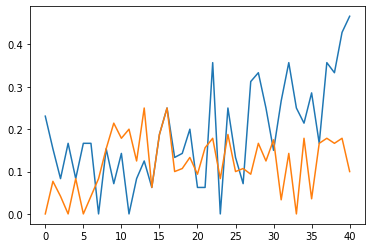

In [117]:
plt.plot(scores)
plt.plot(np.mean(shuff_scores,axis=1))

In [108]:
df=female_df.copy()
df = df.astype({'time':'int'})

minm = 3 # find time points and cages with at least 3 mice per cage
minc=4 # find time points with at least 3 cages

ind=[]
for t in sorted(df.time.unique()):
    curr_df = df[df.time==t] # get data for current time point
    mouse_count = curr_df.groupby('cage')['mouse'].nunique() # find number of mice in each cage
    cages = list(mouse_count[mouse_count >= minm].index) # find cages with more than 3 mice
    if len(cages) >= minc: # make sure there are a minimum number of cages in this time point that have minumum mice
        ind.append(list(curr_df[curr_df.cage.isin(cages)].index)) # save appropriate data indices
ind = np.concatenate(ind)
data = df.loc[ind]

In [109]:
# set decoder params
cv = LeaveOneOut()
clf = RandomForestClassifier(n_estimators = 200,class_weight='balanced')
it=10
#clf = LinearSVC(class_weight='balanced')
scores=[]
shuff_scores=[]
for t in sorted(data.time.unique()):
    data2=data[data.time==t]
    X=data2.drop(['mouse','cage','time'], axis=1).to_numpy()
    y = data2.cage.to_numpy()
    scores.append(np.mean(cross_val_score(clf, X, y, scoring='accuracy',cv=cv)))
    sc=[]
    for i in range(it):
        shuff_y = np.random.permutation(y)
        sc.append(np.mean(cross_val_score(clf, X, shuff_y, scoring='accuracy',cv=cv)))
    shuff_scores.append(sc)

KeyboardInterrupt: 

In [ ]:
plt.plot(scores)
plt.plot(np.mean(shuff_scores,axis=1))